# Część pierwsza
Określenie celów biznesowych oraz stworzenie ramki danych która będzie nadawała się do użycia w trenowaniu modeli

### Cel projektu
Celem projektu jest zbudowanie efektywnego modelu klasteryzacji, który pozwoli na segmentację filmów i seriali dostępnych na platformie streamingowej Netflix na grupy o podobnych cechach. Dzięki temu możliwe będzie tworzenie spersonalizowanych i trafnych rekomendacji kolejnych produkcji dla użytkowników, zwiększając ich zaangażowanie oraz satysfakcję z korzystania z serwisu.
### Cele biznesowe
Zwiększenie retencji użytkowników — poprzez proponowanie filmów i seriali zgodnych z ich indywidualnymi preferencjami, co przekłada się na dłuższy czas spędzany na platformie.

Optymalizacja procesu rekomendacji — poprzez wykorzystanie klasteryzacji do grupowania podobnych treści, co pozwala na szybsze i bardziej precyzyjne dobieranie propozycji.

Podniesienie jakości doświadczenia użytkownika — dzięki rekomendacjom trafiającym w gusta odbiorców, co zwiększa ich zadowolenie i pozytywne opinie o platformie.

Wzrost przychodów — pośrednio poprzez zwiększenie liczby aktywnych użytkowników i ich zaangażowania, co może skutkować większą sprzedażą subskrypcji i przychodami z reklam.

## Tę sekcję trzeba odpalić jeżeli chcemy od razu przejść do testowania modeli
Jeżeli chcemy zrobić hiperparametryzacje to trzeba również wykonać kod w sekcji "Przetwarzanie tekstu" do momentu przypisania df_optimised kolumny text.

In [18]:
try:
    import torch
    print("Torch CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        try:
            import cuml
            import cudf
            print("cuML and cuDF imported successfully.")
        except ImportError as e:
            print(f"Error importing cuML/cuDF: {e}")
            print("Please ensure RAPIDS is installed correctly and is compatible with your CUDA environment.")
    else:
        print("CUDA not available. cuML and cuDF require a CUDA-enabled GPU.")
except ImportError:
    print("Torch is not installed. Please install torch to check CUDA availability.")

import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, DBSCAN

from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as shc

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    pairwise_distances,
)
#import umap.umap_ as umap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from transformers import BertTokenizer, BertModel
import torch

# --- USUNIĘTE LUB ZAKOMENTOWANE (wymagają Linuxa i GPU): ---
# import cuml
# from cuml.manifold import TSNE
# import cupy as cp

# --- ZAMIAST TEGO UŻYJ WERSJI NA PROCESOR (CPU): ---
from sklearn.manifold import TSNE
import numpy as np # Używaj numpy zamiast cupy

import kagglehub
import optuna



Torch CUDA available: False
CUDA not available. cuML and cuDF require a CUDA-enabled GPU.


[nltk_data] Downloading package stopwords to C:\Users\Gabriel
[nltk_data]     Grabowski\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Wczytanie danych i pierwsze spojrzenie

In [7]:
path = kagglehub.dataset_download("bhargavchirumamilla/netflix-movies-and-tv-shows-till-2025")

movies_path = os.path.join(path, "netflix_movies_detailed_up_to_2025.csv")
tvshows_path = os.path.join(path, "netflix_tv_shows_detailed_up_to_2025.csv")

raw_movies = pd.read_csv(movies_path)
raw_tvshows = pd.read_csv(tvshows_path)

print("Filmy:", raw_movies.shape)
print("Programy TV:", raw_tvshows.shape)


Filmy: (16000, 18)
Programy TV: (16000, 16)


In [8]:
# raw_movies = pd.read_csv("netflix_movies_detailed_up_to_2025.csv")
# raw_tvshows = pd.read_csv("netflix_tv_shows_detailed_up_to_2025.csv")

In [9]:
raw_movies.head()

show_id   type                                         title  \
0    10192  Movie                           Shrek Forever After   
1    27205  Movie                                     Inception   
2    12444  Movie  Harry Potter and the Deathly Hallows: Part 1   
3    38757  Movie                                       Tangled   
4    10191  Movie                      How to Train Your Dragon   

                      director  \
0                Mike Mitchell   
1            Christopher Nolan   
2                  David Yates   
3   Byron Howard, Nathan Greno   
4  Chris Sanders, Dean DeBlois   

                                                cast  \
0  Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...   
1  Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...   
2  Daniel Radcliffe, Emma Watson, Rupert Grint, T...   
3  Mandy Moore, Zachary Levi, Donna Murphy, Ron P...   
4  Jay Baruchel, Gerard Butler, Craig Ferguson, A...   

                                    country  date_added  release_year  rating  \
0                  United States of America  2010-05-16          2010   6.380   
1  United Kingdom, United States of America  2010-07-15          2010   8.369   
2  United Kingdom, United States of America  2010-11-17          2010   7.744   
3                  United States of America  2010-11-24          2010   7.600   
4                  United States of America  2010-03-18          2010   7.800   

   duration                                         genres language  \
0       NaN  Comedy, Adventure, Fantasy, Animation, Family       en   
1       NaN             Action, Science Fiction, Adventure       en   
2       NaN                             Adventure, Fantasy       en   
3       NaN                   Animation, Family, Adventure       en   
4       NaN          Fantasy, Adventure, Animation, Family       en   

                                         description  popularity  vote_count  \
0  A bored and domesticated Shrek pacts with deal...     203.893        7449   
1  Cobb, a skilled thief who commits corporate es...     156.242       37119   
2  Harry, Ron and Hermione walk away from their l...     121.191       19327   
3  Feisty teenager Rapunzel, who has long and mag...     111.762       11638   
4  As the son of a Viking leader on the cusp of m...     110.044       13259   

   vote_average     budget    revenue  
0         6.380  165000000  752600867  
1         8.369  160000000  839030630  
2         7.744  250000000  954305868  
3         7.600  260000000  592461732  
4         7.800  165000000  494879471

In [10]:
raw_tvshows.head()

show_id     type              title director  \
0    33238  TV Show        Running Man      안재철   
1    32415  TV Show              Conan      NaN   
2    37757  TV Show  MasterChef Greece      NaN   
3    75685  TV Show         Prostřeno!      NaN   
4    33847  TV Show           The Talk      NaN   

                                                cast  \
0  Yoo Jae-suk, Jee Seok-jin, Kim Jong-kook, Haha...   
1                        Conan O'Brien, Andy Richter   
2                                                NaN   
3                        Václav Vydra, Jana Boušková   
4  Amanda Kloots, Jerry O'Connell, Akbar Gbaja-Bi...   

                             country  date_added  release_year  rating  \
0                        South Korea  2010-07-11          2010   8.241   
1           United States of America  2010-11-08          2010   7.035   
2                             Greece  2010-10-03          2010   5.600   
3                     Czech Republic  2010-03-01          2010   6.500   
4  United States of America, Ireland  2010-10-18          2010   3.400   

    duration              genres language  \
0  1 Seasons     Comedy, Reality       ko   
1  1 Seasons  Talk, Comedy, News       en   
2  1 Seasons             Reality       el   
3  1 Seasons             Reality       cs   
4  1 Seasons                Talk       en   

                                         description  popularity  vote_count  \
0  A reality and competition show where members a...    1929.898         187   
1  A late night television talk show hosted by  C...    1670.580         229   
2  MasterChef Greece is a Greek competitive cooki...    1317.092           6   
3  The knives (and forks) are out as a group of s...    1095.776           6   
4  A panel of well-known news and entertainment p...     712.070          12   

   vote_average  
0         8.241  
1         7.035  
2         5.600  
3         6.500  
4         3.400

### Czyszczenie i uzupełnianie danych
Możemy zauważyć, że kolumna duration jest całkowicie niepotrzebna (te same wartości), natomiast kolumny "budget" i "revenue" są pod kątem celu biznesowego bezużyteczne, ponieważ użytkownicy raczej nie wybierają filmów na podstawie tego, ile kosztowały lub ile zarobiły. Ponadto, kolumna "vote_average" jest redundantna z kolumną "rating", a "date_added", to po prostu rozszerzona wersja "release_year", zatem też możemy ją usunąć. Zauważamy też, że kolumny "country" i "language" są bardzo silnie skorelowane, wobec tego możemy usunąć tę, która zawiera NaNy, czyli "country". Ostatecznie, możemy pozbyć się również "show_id", które nie wnosi nic do klasteryzacji.


In [11]:
raw_tvshows["budget"] = np.nan
raw_tvshows["revenue"] = np.nan
df = pd.concat([raw_movies, raw_tvshows])
df.drop("duration", axis=1, inplace=True)
df.drop("budget", axis=1, inplace=True)
df.drop("revenue", axis=1, inplace=True)
df.drop("vote_average", axis=1, inplace=True)
df.drop("date_added", axis=1, inplace=True)
df.drop("country", axis=1, inplace=True)
df.drop("show_id", axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32000 entries, 0 to 15999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          32000 non-null  object 
 1   title         32000 non-null  object 
 2   director      20903 non-null  object 
 3   cast          30639 non-null  object 
 4   release_year  32000 non-null  int64  
 5   rating        32000 non-null  float64
 6   genres        30919 non-null  object 
 7   language      32000 non-null  object 
 8   description   28662 non-null  object 
 9   popularity    32000 non-null  float64
 10  vote_count    32000 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 2.9+ MB


Zauważamy, że 4 kolumny są częściowo wypełnione NaNami. Dobrą i prostą strategią jest zmiana tych wartości na puste stringi.

In [13]:
text_cols = ['director', 'cast', 'genres', 'description']
df[text_cols] = df[text_cols].fillna("")

In [14]:
df.head()

type                                         title  \
0  Movie                           Shrek Forever After   
1  Movie                                     Inception   
2  Movie  Harry Potter and the Deathly Hallows: Part 1   
3  Movie                                       Tangled   
4  Movie                      How to Train Your Dragon   

                      director  \
0                Mike Mitchell   
1            Christopher Nolan   
2                  David Yates   
3   Byron Howard, Nathan Greno   
4  Chris Sanders, Dean DeBlois   

                                                cast  release_year  rating  \
0  Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...          2010   6.380   
1  Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...          2010   8.369   
2  Daniel Radcliffe, Emma Watson, Rupert Grint, T...          2010   7.744   
3  Mandy Moore, Zachary Levi, Donna Murphy, Ron P...          2010   7.600   
4  Jay Baruchel, Gerard Butler, Craig Ferguson, A...          2010   7.800   

                                          genres language  \
0  Comedy, Adventure, Fantasy, Animation, Family       en   
1             Action, Science Fiction, Adventure       en   
2                             Adventure, Fantasy       en   
3                   Animation, Family, Adventure       en   
4          Fantasy, Adventure, Animation, Family       en   

                                         description  popularity  vote_count  
0  A bored and domesticated Shrek pacts with deal...     203.893        7449  
1  Cobb, a skilled thief who commits corporate es...     156.242       37119  
2  Harry, Ron and Hermione walk away from their l...     121.191       19327  
3  Feisty teenager Rapunzel, who has long and mag...     111.762       11638  
4  As the son of a Viking leader on the cusp of m...     110.044       13259

Zatem ostatecznie oczyściliśmy zbiór z wartości NaN:

In [15]:
df.isnull().sum()

type            0
title           0
director        0
cast            0
release_year    0
rating          0
genres          0
language        0
description     0
popularity      0
vote_count      0
dtype: int64

Sprawdzenie unikalności wartości w danych kolumnach:

In [16]:
for i in df.columns.tolist():
  print("Liczba unikalnych wartości",i,"wynosi",df[i].nunique())

Liczba unikalnych wartości type wynosi 2
Liczba unikalnych wartości title wynosi 30639
Liczba unikalnych wartości director wynosi 13012
Liczba unikalnych wartości cast wynosi 30231
Liczba unikalnych wartości release_year wynosi 16
Liczba unikalnych wartości rating wynosi 2728
Liczba unikalnych wartości genres wynosi 3896
Liczba unikalnych wartości language wynosi 83
Liczba unikalnych wartości description wynosi 28637
Liczba unikalnych wartości popularity wynosi 24159
Liczba unikalnych wartości vote_count wynosi 2902


In [17]:
df_klastry = df.copy()
df_optymalizacja = df.copy()

## Eksploracyjna analiza danych
Będziemy po kolei, od lewej do prawej, analizować każdą kolumnę w zbiorze danych,

Dystrybucja wartości w kolumnie "type":

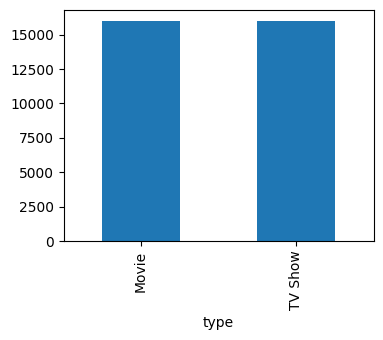

In [14]:
df['type'].value_counts().plot.bar(figsize=(4,3))
plt.show()

Oczywiście zarówno Movie jak i TV Show są tak samo liczne (16000), co wynika ze sklejenia dwóch równolicznych zbiorów danych.
Sprawdźmy teraz jak często występują dane słowa w tytułach filmów i seriali. Posłuży nam do tego biblioteka wordcloud.

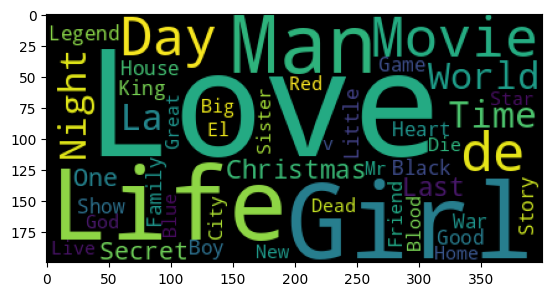

In [15]:
text = " ".join(word for word in df['title'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', min_font_size=15).generate(text)
plt.imshow(wordcloud)
plt.show()

Zajmijmy się teraz kolumną "director":

In [16]:
df['director'].str.split(', ', expand=True).stack().value_counts() # ponieważ jedna produkcja może mieć wielu reżyserów

11097
Don Michael Perez          21
Dominic Zapata             21
Tyler Perry                20
Sam Liu                    18
                        ...  
Billy Arthur                1
Jean-Pierre Canet           1
Raphael Tresanini           1
Konstantin Bock             1
Anne Zohra Berrached        1
Name: count, Length: 14030, dtype: int64

In [17]:
df['director'].str.split(', ', expand=True).stack().value_counts().iloc[0]

np.int64(11097)

11097 filmów/seriali ma brakującą wartość w kolumnie "director". Sprawdźmy jednak czy to są bardziej filmy, czy seriale.

<Axes: xlabel='type'>

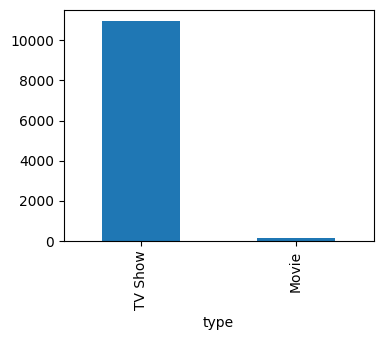

In [18]:
df[df['director'] == '']['type'].value_counts().plot.bar(figsize=(4,3))

Jak widać, przeważająca większość brakującej wartości w kolumnie 'director' występuje dla seriali.
Przedstawmy jeszcze wykres, który pokazuje, którzy reżyserzy sprawowali opiekę nad produkcjami najczęściej:

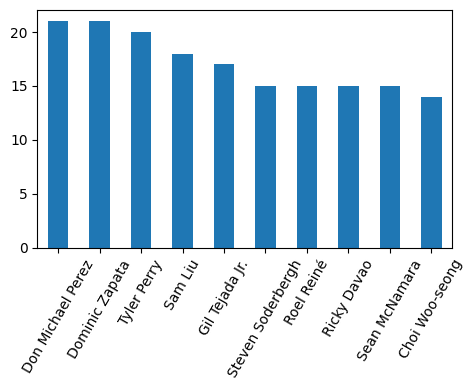

In [19]:
df['director'].str.split(', ', expand=True).stack().value_counts()[1:11].plot.bar(figsize=(5,4))
plt.xticks(rotation=60)  # lub 45 dla większego przechylenia
plt.tight_layout()
plt.show()

Analogiczną analizę możemy przeprowadzić teraz dla kolumny "cast", czyli aktorów.

In [20]:
df['cast'].str.split(', ', expand=True).stack().value_counts() # ponieważ jedna produkcja może mieć wielu aktorów

1361
Min Do-yoon         111
Kana Hanazawa        97
Yuki Kaji            70
Grey DeLisle         65
                   ... 
Vickie Papavs         1
Patrice Goodman       1
Saško Kocev           1
Matej Sivakov         1
Marshall Napier       1
Name: count, Length: 59712, dtype: int64

In [21]:
df['cast'].str.split(', ', expand=True).stack().value_counts().iloc[0]

np.int64(1361)

Mamy 1361 wierszy z pustą wartością w kolumnie "cast". Analogicznie możemy sprawdzić, czy jest ich więcej wśród filmów, czy seriali.

<Axes: xlabel='type'>

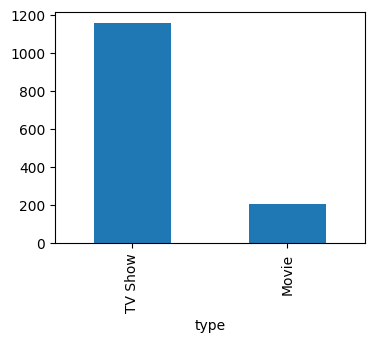

In [22]:
df[df['cast'] == '']['type'].value_counts().plot.bar(figsize=(4,3))

Znów mamy przewagę (lecz nie zatrważającą) seriali, jeśli chodzi o puste wartości. Przedstawmy wykres aktorów grających w największej liczbie filmów oraz seriali:

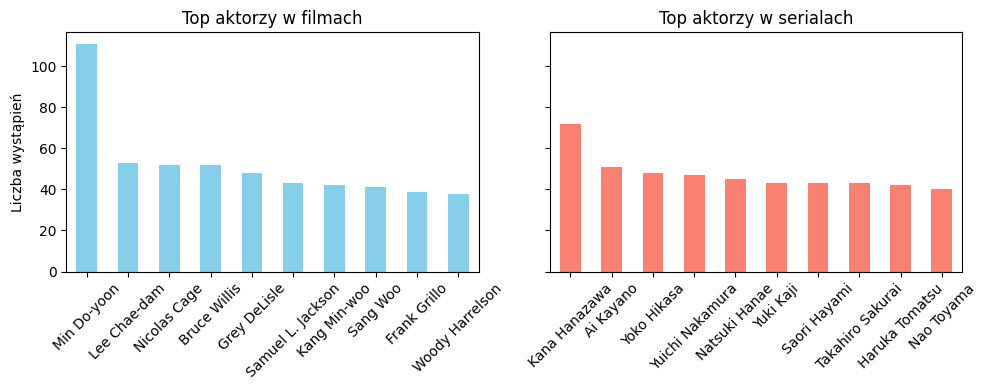

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# wykres dla filmów
df[df['type'] == 'Movie']['cast'].str.split(', ', expand=True).stack().value_counts()[1:11].plot.bar(ax=axes[0], color='skyblue', rot=45)
axes[0].set_title('Top aktorzy w filmach')
axes[0].set_ylabel('Liczba wystąpień')

# wykres dla seriali
df[df['type'] == 'TV Show']['cast'].str.split(', ', expand=True).stack().value_counts()[1:11].plot.bar(ax=axes[1], color='salmon', rot=45)
axes[1].set_title('Top aktorzy w serialach')

plt.tight_layout()
plt.show()


Prześledzmy teraz rozkład liczności roku wydania produkcji:

<Axes: xlabel='release_year'>

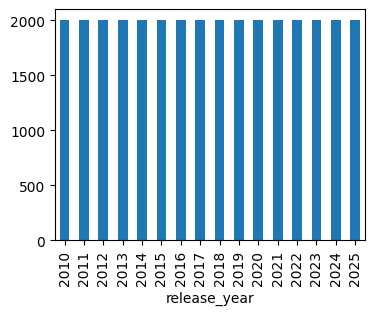

In [24]:
df['release_year'].value_counts().plot.bar(figsize=(4,3))

Zbiór danych został tak skonstruowany, żeby dla każdego z lat 2010-2025 było po 2000 produkcji. Prześledźmy teraz kolumnę "rating":

<Axes: >

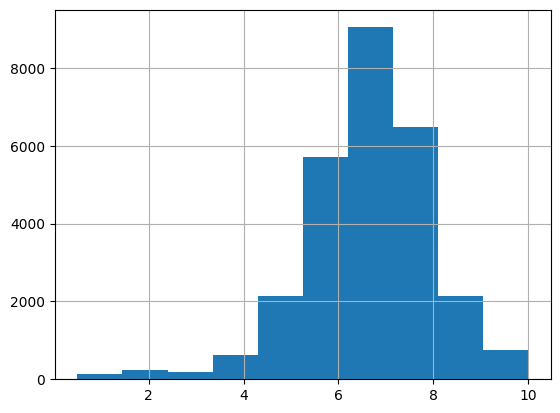

In [25]:
df[df['rating'] > 0]['rating'].hist()

Z powyższego histogramu wyłączyliśmy te produkcje, które mają rating 0.0, gdyż wynika to po prostu z braku głosów.

In [26]:
len(df[df['rating'] == 0])

4572

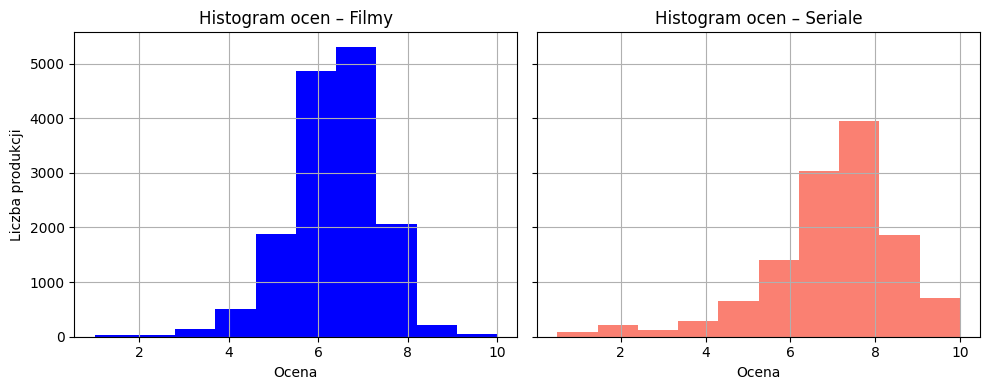

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Histogram dla filmów
df[(df['rating'] > 0) & (df['type'] == 'Movie')]['rating'].hist(ax=axes[0], color='blue')
axes[0].set_title('Histogram ocen – Filmy')
axes[0].set_xlabel('Ocena')
axes[0].set_ylabel('Liczba produkcji')

# Histogram dla seriali
df[(df['rating'] > 0) & (df['type'] == 'TV Show')]['rating'].hist(ax=axes[1], color='salmon')
axes[1].set_title('Histogram ocen – Seriale')
axes[1].set_xlabel('Ocena')

plt.tight_layout()
plt.show()


In [28]:
df[(df['type'] == 'Movie') & (df['rating'] > 0)]['rating'].describe()

count    15101.000000
mean         6.310965
std          1.012144
min          1.000000
25%          5.731000
50%          6.400000
75%          7.000000
max         10.000000
Name: rating, dtype: float64

In [29]:
df[(df['type'] == 'TV Show') & (df['rating'] > 0)]['rating'].describe()

count    12327.000000
mean         7.031209
std          1.580975
min          0.500000
25%          6.300000
50%          7.200000
75%          8.000000
max         10.000000
Name: rating, dtype: float64

Kolumna "genres". Prześledźmy jej zachowanie:

In [30]:
df['genres'].str.split(', ', expand=True).stack().value_counts()

Drama                 14776
Comedy                 9110
Animation              4070
Thriller               3769
Action                 3239
Crime                  3203
Family                 3014
Mystery                2576
Romance                2571
Horror                 2425
Action & Adventure     1988
Sci-Fi & Fantasy       1958
Documentary            1827
Adventure              1768
Reality                1632
Science Fiction        1454
Fantasy                1450
                       1081
Kids                    835
History                 732
Talk                    655
Soap                    631
TV Movie                628
Music                   488
War                     420
War & Politics          323
Western                 154
News                    113
Unknown                 104
Name: count, dtype: int64

Sprawdźmy w jakich językach jest najwięcej produkcji (kolumna "language"):

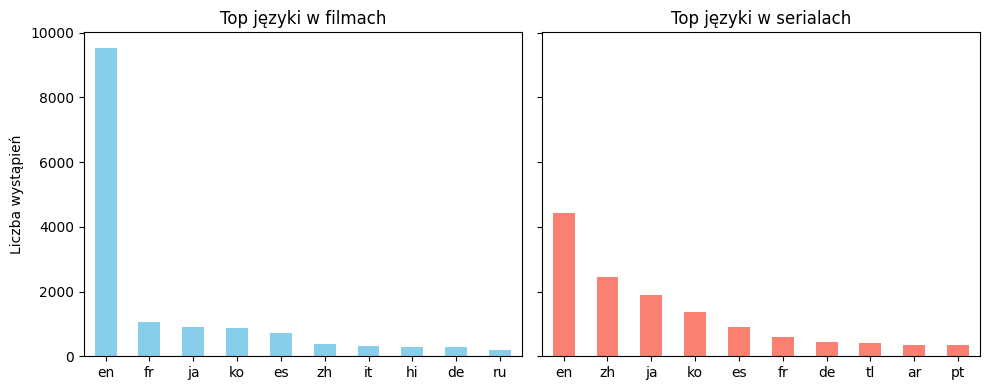

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# wykres dla filmów
df[df['type'] == 'Movie']['language'].str.split(', ', expand=True).stack().value_counts()[:10].plot.bar(ax=axes[0], color='skyblue', rot=0)
axes[0].set_title('Top języki w filmach')
axes[0].set_ylabel('Liczba wystąpień')

# wykres dla seriali
df[df['type'] == 'TV Show']['language'].str.split(', ', expand=True).stack().value_counts()[:10].plot.bar(ax=axes[1], color='salmon', rot=0)
axes[1].set_title('Top języki w serialach')

plt.tight_layout()
plt.show()

Obserwacje: zarówno w filmach, jak i w serialach językiem przewodnim jest język angielski. Warto podkreślić, że języki wschodnioazjatyckie są również bardzo popularne wśród seriali na Netflixie. Jeśli chodzi o kolumnę "description", można przedstawić częstość występowania danych słów, w analogii do "title":

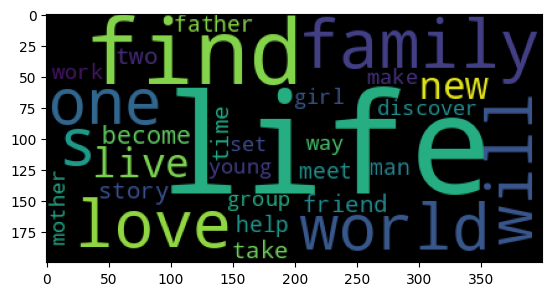

In [32]:
text = " ".join(word for word in df['description'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', min_font_size=15).generate(text)
plt.imshow(wordcloud)
plt.show()

Sprawdźmy jak zachowują się wartości z kolumny "popularity" dla filmów i seriali.

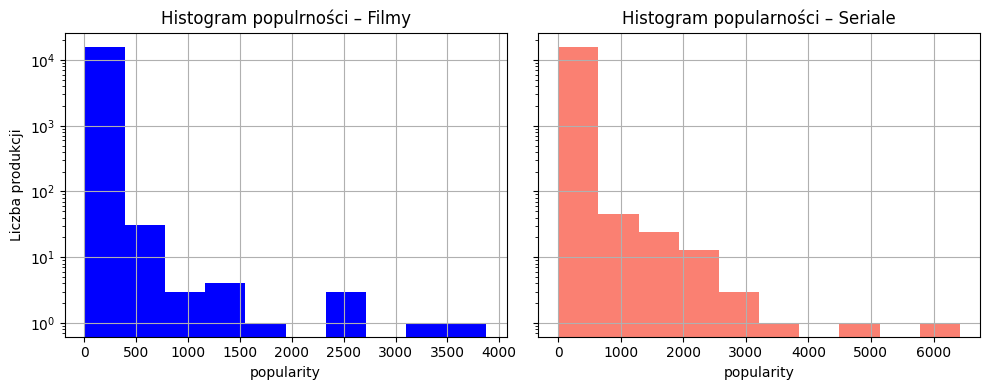

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Histogram dla filmów
df[df['type'] == 'Movie']['popularity'].hist(ax=axes[0], color='blue')
axes[0].set_title('Histogram populrności – Filmy')
axes[0].set_xlabel('popularity')
axes[0].set_ylabel('Liczba produkcji')
axes[0].set_yscale('log')  # <- logarytmiczna skala

# Histogram dla seriali
df[df['type'] == 'TV Show']['popularity'].hist(ax=axes[1], color='salmon')
axes[1].set_title('Histogram popularności – Seriale')
axes[1].set_xlabel('popularity')
axes[1].set_yscale('log')  # <- logarytmiczna skala

plt.tight_layout()
plt.show()

In [34]:
df[df['type'] == 'Movie']['popularity'].describe()

count    16000.000000
mean        20.384728
std         68.610033
min          3.860000
25%          7.840750
50%         10.913500
75%         17.336500
max       3876.006000
Name: popularity, dtype: float64

In [35]:
df[df['type'] == 'TV Show']['popularity'].describe()

count    16000.000000
mean        64.850984
std        139.387289
min          2.323000
25%         24.874750
50%         36.187500
75%         62.187500
max       6421.923000
Name: popularity, dtype: float64

Analogicznie postąpimy z kolumną "vote_count":

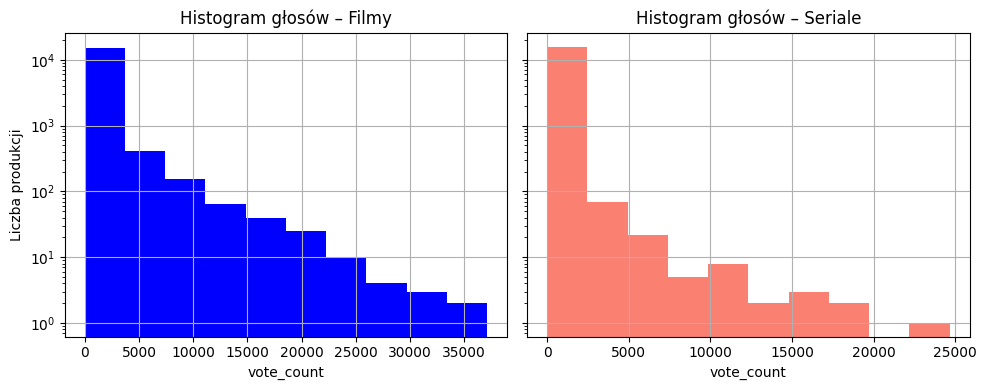

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Histogram dla filmów
df[df['type'] == 'Movie']['vote_count'].hist(ax=axes[0], color='blue')
axes[0].set_title('Histogram głosów – Filmy')
axes[0].set_xlabel('vote_count')
axes[0].set_ylabel('Liczba produkcji')
axes[0].set_yscale('log')  # <- logarytmiczna skala

# Histogram dla seriali
df[df['type'] == 'TV Show']['vote_count'].hist(ax=axes[1], color='salmon')
axes[1].set_title('Histogram głosów – Seriale')
axes[1].set_xlabel('vote_count')
axes[1].set_yscale('log')  # <- logarytmiczna skala

plt.tight_layout()
plt.show()

In [37]:
df[df['type'] == 'Movie']['vote_count'].describe()

count    16000.000000
mean       718.656125
std       2080.198316
min          0.000000
25%         53.000000
50%        138.000000
75%        422.000000
max      37119.000000
Name: vote_count, dtype: float64

In [38]:
df[df['type'] == 'TV Show']['vote_count'].describe()

count    16000.000000
mean       107.014313
std        607.461581
min          0.000000
25%          1.000000
50%          4.000000
75%         30.000000
max      24664.000000
Name: vote_count, dtype: float64

## Przetwarzanie tekstu
Teraz będziemy sobie chcieli jakoś poradzić z kolumnami tekstowymi, żeby je ujednolicić i żeby były one wartościowe dla procesu klasteryzacji.

Dobrym pomysłem będzie najpierw utworzenie nowej kolumny, która zawiera wszystkie skonkatenowane kolumny tekstowe.

In [18]:
df['type'] = df['type'].map({'Movie': 1, 'TV Show': 0})


In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['language']= label_encoder.fit_transform(df['language'])


In [20]:
from sklearn.preprocessing import MultiLabelBinarizer

df['genres_list'] = df['genres'].apply(lambda x: [genre.strip() for genre in x.split(',')])
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['genres_list'])

genre_df = pd.DataFrame(genre_labels, columns=mlb.classes_, index=df.index)
df = pd.concat([df, genre_df], axis=1)

In [21]:
df['text'] = "TITLE: " + df['title'] + " DIRECTOR: " + df['director'] + " CAST: " + df['cast'] + " DESCRIPTION: " + df['description']

In [22]:
df.shape

(32000, 42)

Następnym krokiem będzie standaryzacja kolumny "text", czyli między innymi usuwanie słów wnoszących niewiele (tzn. stopwords), pozbycie się wielkich liter, znaków interpunkcyjnych, czy przywrócenie słów do swoich nominalnych form (mianownik, liczba pojedyncza, bezokolicznik...)

In [23]:
stop_words = stopwords.words('english')

In [24]:
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [25]:
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

In [26]:
df['text'] = df['text'].apply(stopwords)

In [27]:
def usun_znaki_interpunkcyjne(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [28]:
df['text'] = df['text'].apply(usun_znaki_interpunkcyjne)

In [29]:
df.iloc[0]['text']

'title shrek forever director mike mitchell cast mike myers eddie murphy cameron diaz antonio banderas walt dohrn description bored domesticated shrek pacts dealmaker rumpelstiltskin get back feeling like real ogre again duped sent twisted version far far away—where rumpelstiltskin king ogres hunted fiona never met—he sets restore world reclaim true love'

In [30]:
def stemming(text):
    text = [SnowballStemmer("english").stem(word) for word in text.split()]
    return " ".join(text)

In [31]:
df['text'] = df['text'].apply(stemming)

In [32]:
df.iloc[0]['text']

'titl shrek forev director mike mitchel cast mike myer eddi murphi cameron diaz antonio bandera walt dohrn descript bore domest shrek pact dealmak rumpelstiltskin get back feel like real ogr again dupe sent twist version far far away—wher rumpelstiltskin king ogr hunt fiona never met—h set restor world reclaim true love'

In [33]:
df_optymalizacja['text'] = df['text']

### BERT

Bert daje lepsze osiągi niż TFDF

In [55]:
print(torch.cuda.is_available())

True


In [56]:
device = torch.device('cuda')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device).eval()

batch_size = 32



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [57]:
embeddings = []

for i in range(0, len(df), batch_size):
    batch = df['text'].iloc[i:i+batch_size].tolist()
    encoded = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
    with torch.no_grad():
        out = model(**encoded)
    embeddings.append(out.pooler_output.cpu().numpy())

df['bert_embedding'] = list(np.vstack(embeddings))

In [58]:
df.shape

(32000, 43)

### Redukcja wymiarów
Spróbujmy zastosować PCA w celu dimensionality reduction.

In [59]:
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=50)
X = pca.fit_transform(np.array(df['bert_embedding'].tolist()))

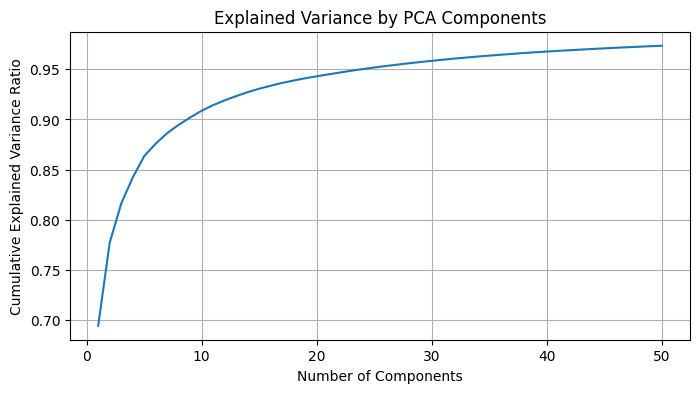

Shape of X_pca: (32000, 50)


In [60]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

print(f"Shape of X_pca: {X.shape}")

Dla UMAP \\
Często potrafi się psuć jeżlei nie ma wystarczającej mocy obliczeniowej

In [61]:
# import umap
# reducer = umap.UMAP(n_components=50, random_state=42)
# X_before = np.vstack(df['bert_embedding'].values)
# X = reducer.fit_transform(X_before)

In [62]:
# from sklearn.manifold import trustworthiness

# trust_umap = trustworthiness(X_before, X, n_neighbors=5)
# print(trust_umap)

In [63]:
print(X.shape)
print(df.shape)
print(df.columns)

(32000, 50)
(32000, 43)
Index(['type', 'title', 'director', 'cast', 'release_year', 'rating', 'genres',
       'language', 'description', 'popularity', 'vote_count', 'genres_list',
       '', 'Action', 'Action & Adventure', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Kids', 'Music', 'Mystery', 'News', 'Reality', 'Romance',
       'Sci-Fi & Fantasy', 'Science Fiction', 'Soap', 'TV Movie', 'Talk',
       'Thriller', 'Unknown', 'War', 'War & Politics', 'Western', 'text',
       'bert_embedding'],
      dtype='object')


In [64]:
used_in_text = ['title', 'director', 'cast', 'description','text', 'bert_embedding','genres_list', 'release_year', 'rating', 'popularity', 'vote_count', 'genres']
df_concatenate = df.drop(columns=used_in_text, errors='ignore')

In [65]:
df_concatenate.head(5)


type  language     Action  Action & Adventure  Adventure  Animation  \
0     1        16  0       0                   0          1          1   
1     1        16  0       1                   0          1          0   
2     1        16  0       0                   0          1          0   
3     1        16  0       0                   0          1          1   
4     1        16  0       0                   0          1          1   

   Comedy  Crime  Documentary  ...  Sci-Fi & Fantasy  Science Fiction  Soap  \
0       1      0            0  ...                 0                0     0   
1       0      0            0  ...                 0                1     0   
2       0      0            0  ...                 0                0     0   
3       0      0            0  ...                 0                0     0   
4       0      0            0  ...                 0                0     0   

   TV Movie  Talk  Thriller  Unknown  War  War & Politics  Western  
0         0     0         0        0    0               0        0  
1         0     0         0        0    0               0        0  
2         0     0         0        0    0               0        0  
3         0     0         0        0    0               0        0  
4         0     0         0        0    0               0        0  

[5 rows x 31 columns]

In [66]:
from sklearn.preprocessing import StandardScaler
numeric_features = df[['release_year', 'rating', 'popularity', 'vote_count']]

scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_features)


In [67]:
import numpy as np
df_concat_numeric = df_concatenate.select_dtypes(include=[np.number])

concatenate_array = df_concat_numeric.to_numpy()

X = np.hstack((X, scaled_numeric, concatenate_array))


In [68]:
X.shape

(32000, 85)

In [69]:
np.save("X_zapisane.npy", X)


# Wdrożenie modelu
Podczas wdrorzenia modeu będziemy posługiwali się metrykami silluethe, calinski-harabasz oraz davies-bouldin. A co oznaczają te poszczególne metryki?
- **Silluethe** mówi nam o separacji klastrów
- **Calinski-Harabasz** mówi o wariancji między klastrami
- **Davies-Bouldin** mówi o rozproszeniu między klastrami

In [36]:
# X = np.load("X_zapisane.npy")

X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)

X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (22400, 85)
Validation: (4800, 85)
Test: (4800, 85)


### Metoda k-means

#### Szacowania

Dobierzmy liczbę klastrów. Użyjmy przy tym klasycznej metody łokcia.

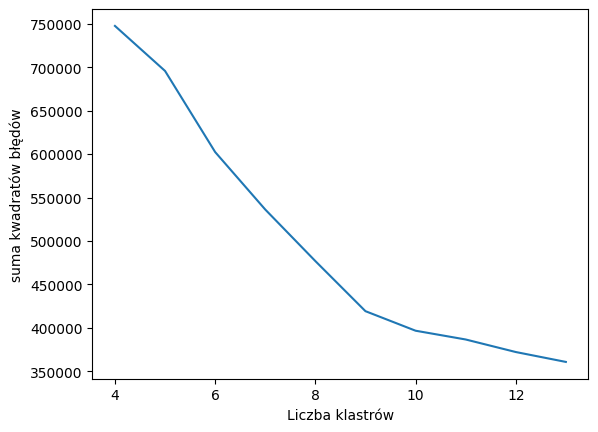

In [20]:
SSE = []

for k in range(4, 14):
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  kmeans.fit(X_train)
  SSE.append(kmeans.inertia_)

plt.plot(range(4, 14), SSE)
plt.xlabel('Liczba klastrów')
plt.ylabel('suma kwadratów błędów')
plt.show()


Trudno wskazać dobrego kandydata z tej metody. Wobec tego użyjemy jeszcze metody silhouette score.

In [21]:
cluster_range = range(4, 14)

models = {}
silhouette_avg = {}
calinski_scores = {}
davies_scores = {}

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_train)
    labels_test = kmeans.predict(X_test)

    models[k] = kmeans
    silhouette_avg[k] = silhouette_score(X_test, labels_test)
    calinski_scores[k] = calinski_harabasz_score(X_test, labels_test)
    davies_scores[k] = davies_bouldin_score(X_test, labels_test)


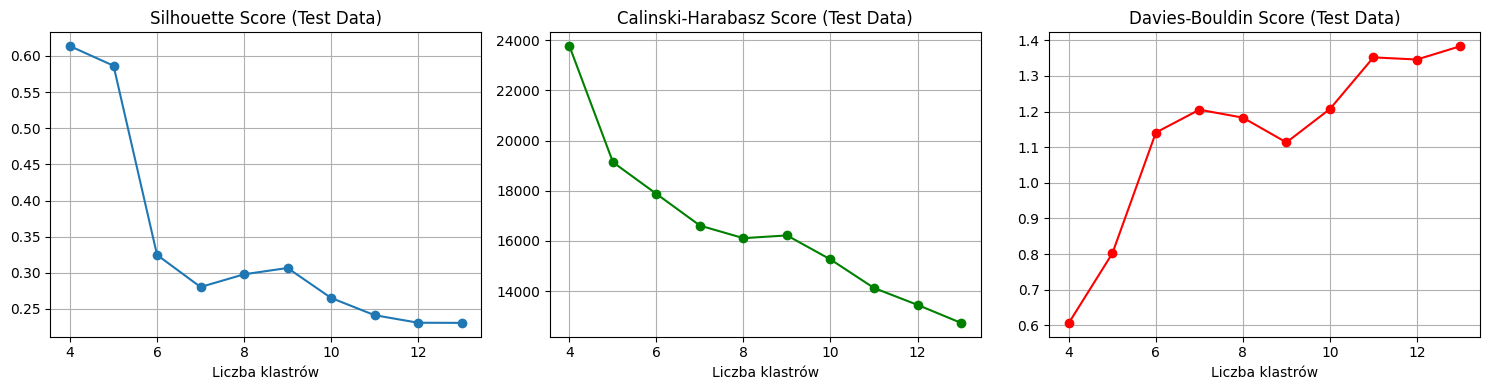

In [22]:
ks = range(4, 14)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(ks, list(silhouette_avg.values()), marker='o')
plt.title('Silhouette Score (Test Data)')
plt.xlabel('Liczba klastrów')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(ks, list(calinski_scores.values()), marker='o', color='green')
plt.title('Calinski-Harabasz Score (Test Data)')
plt.xlabel('Liczba klastrów')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(ks, list(davies_scores.values()), marker='o', color='red')
plt.title('Davies-Bouldin Score (Test Data)')
plt.xlabel('Liczba klastrów')
plt.grid(True)

plt.tight_layout()
plt.show()


#### Wybór

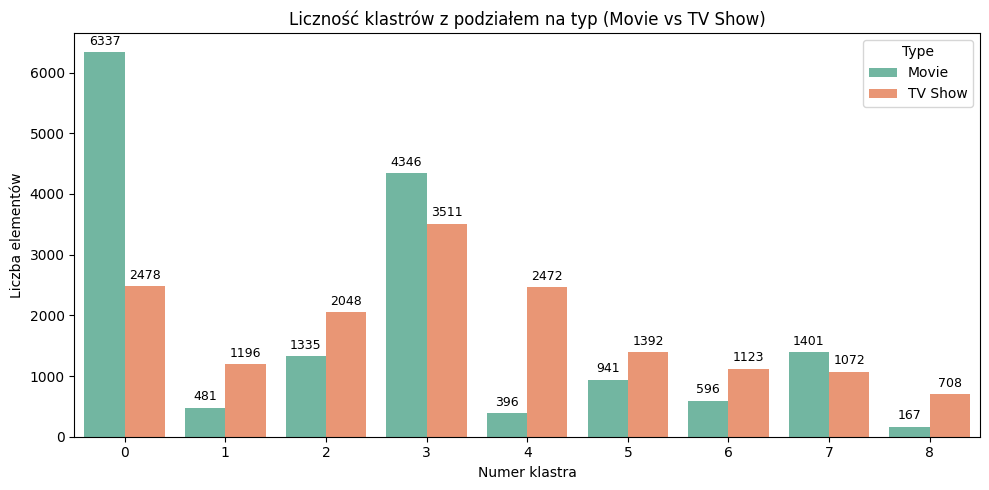

In [53]:
kmeans = KMeans(n_clusters=9, init='k-means++', random_state=42)
kmeans.fit(X_train)
df_klastry['kmeans_cluster_number'] = kmeans.predict(X)

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_klastry, x='kmeans_cluster_number', hue='type', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

plt.title('Liczność klastrów z podziałem na typ (Movie vs TV Show)')
plt.xlabel('Numer klastra')
plt.ylabel('Liczba elementów')
plt.legend(title='Type')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-06-06 10:38:51.910] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


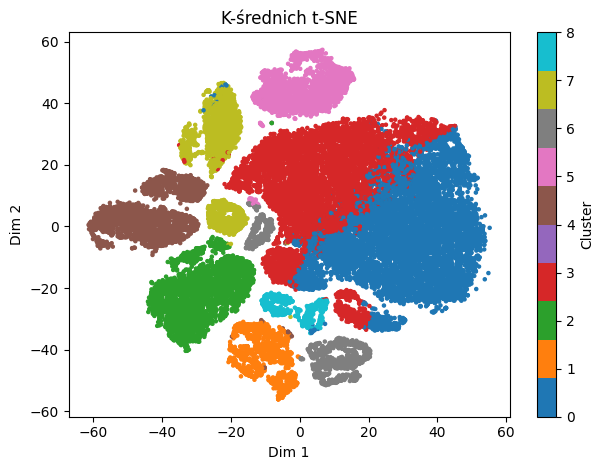

In [54]:
X_gpu = cp.asarray(X)
tsne = TSNE(n_components=2, perplexity=30,n_neighbors=90, n_iter=500, random_state=42)
X_tsne_gpu = tsne.fit_transform(X_gpu)

X_tsne = cp.asnumpy(X_tsne_gpu)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_klastry['kmeans_cluster_number'], cmap='tab10', s=5)
plt.title("K-średnich t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


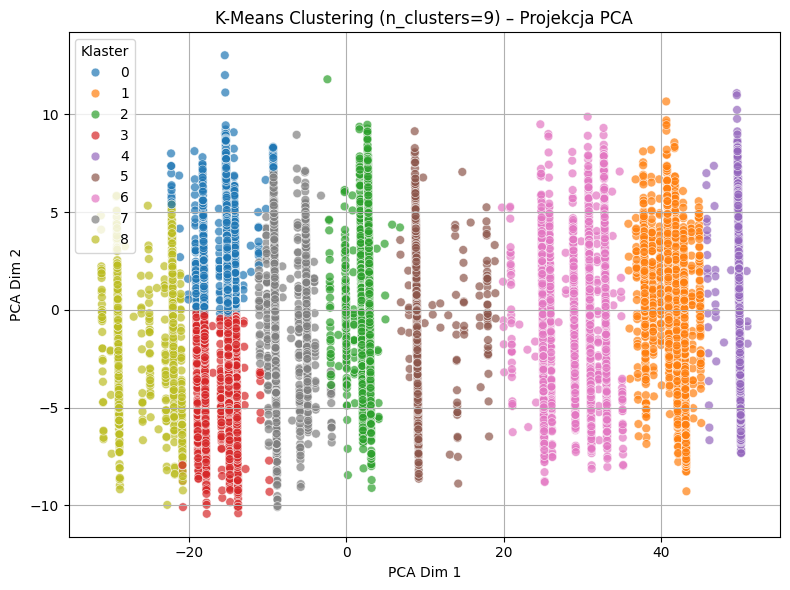

In [55]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_klastry['kmeans_cluster_number'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title(f"K-Means Clustering (n_clusters={len(set(df_klastry['kmeans_cluster_number']))}) – Projekcja PCA")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### Metoda MiniBatch K-means

#### Szacowania

Analogicznie jak w K-means, spróbujmy dobrać liczbę klastrów metodą silhouette score.

In [26]:
labels_dict = {}
models_dict = {}
silhouette_scores = []
calinski_scores = []
davies_scores = []

for k in range(4, 14):
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    mbk.fit(X_train)
    labels_test = mbk.predict(X_test)

    models_dict[k] = mbk
    labels_dict[k] = labels_test

    silhouette_scores.append(silhouette_score(X_test, labels_test))
    calinski_scores.append(calinski_harabasz_score(X_test, labels_test))
    davies_scores.append(davies_bouldin_score(X_test, labels_test))

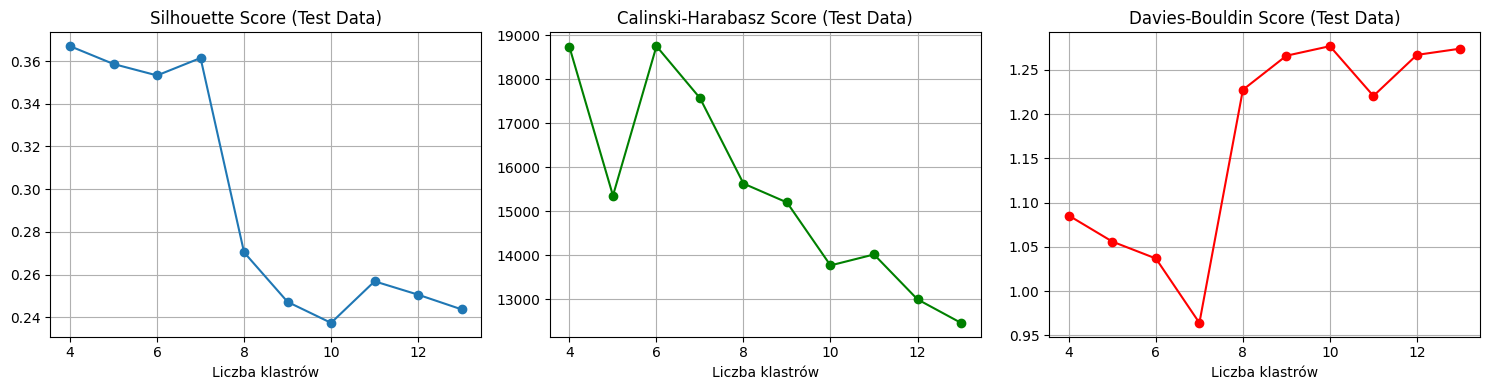

In [27]:
ks = range(4, 14)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(ks, silhouette_scores, marker='o')
plt.title('Silhouette Score (Test Data)')
plt.xlabel('Liczba klastrów')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(ks, calinski_scores, marker='o', color='green')
plt.title('Calinski-Harabasz Score (Test Data)')
plt.xlabel('Liczba klastrów')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(ks, davies_scores, marker='o', color='red')
plt.title('Davies-Bouldin Score (Test Data)')
plt.xlabel('Liczba klastrów')
plt.grid(True)

plt.tight_layout()
plt.show()

W tym wypadku dobierzemy zobaczymy jak będą będzie wyglądało dla 4 oraz 5 klastrów

#### Wybór

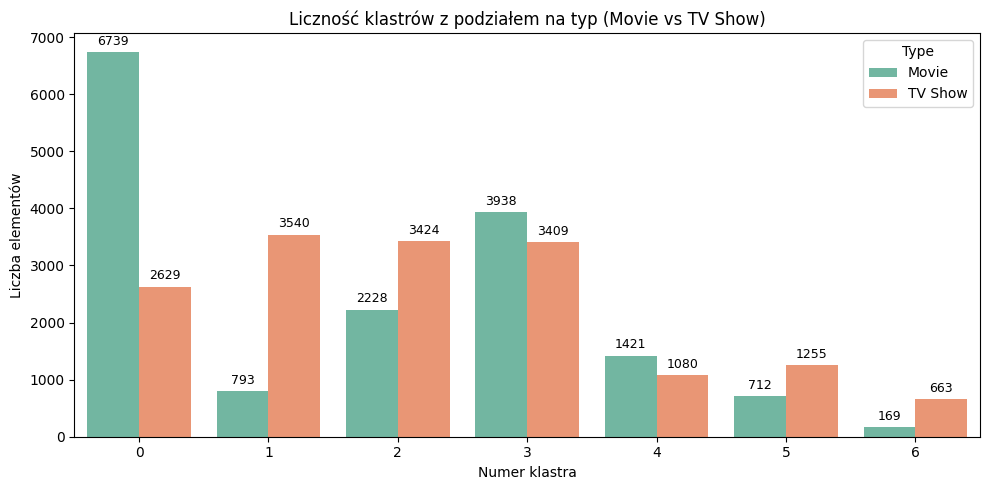

In [49]:
model = MiniBatchKMeans(n_clusters=7, random_state=42, batch_size=1000)
model.fit(X_train)
df_klastry['cluster_miniBatches'] = model.predict(X)

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_klastry, x='cluster_miniBatches', hue='type', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

plt.title('Liczność klastrów z podziałem na typ (Movie vs TV Show)')
plt.xlabel('Numer klastra')
plt.ylabel('Liczba elementów')
plt.legend(title='Type')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-06-06 10:36:39.912] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


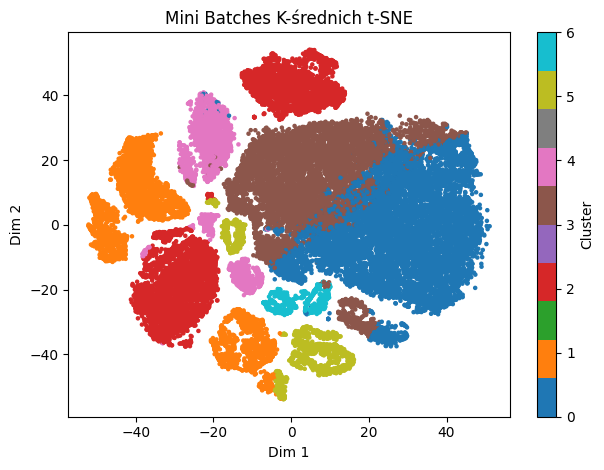

In [50]:
X_gpu = cp.asarray(X)

tsne = TSNE(n_components=2, perplexity=30,n_neighbors=90, n_iter=500, random_state=42)
X_tsne_gpu = tsne.fit_transform(X_gpu)

X_tsne = cp.asnumpy(X_tsne_gpu)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_klastry['cluster_miniBatches'], cmap='tab10', s=5)
plt.title("Mini Batches K-średnich t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


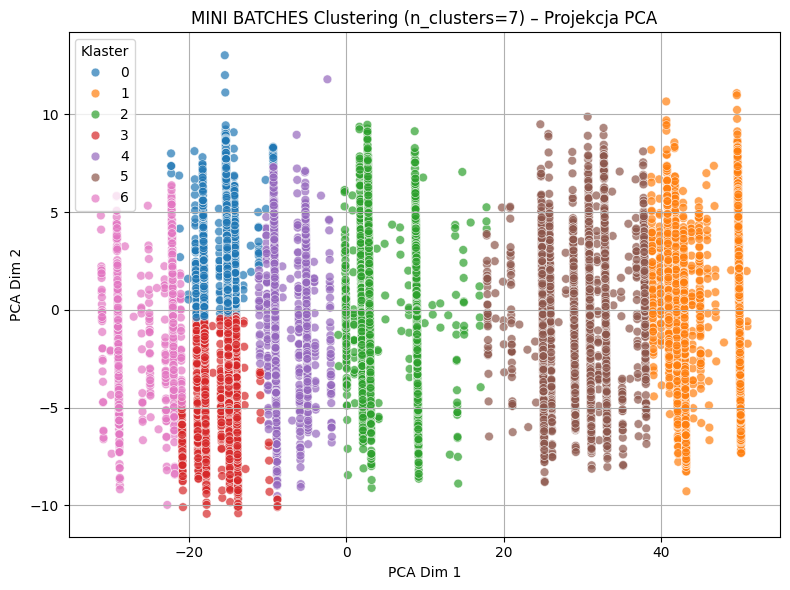

In [51]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_klastry['cluster_miniBatches'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title(f"MINI BATCHES Clustering (n_clusters={len(set(df_klastry['cluster_miniBatches']))}) – Projekcja PCA")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### DBSCAN

#### Szacowanie

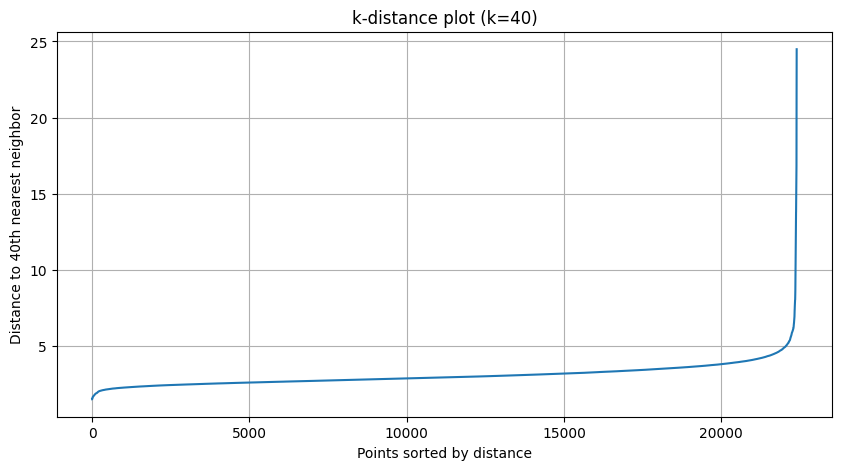

In [83]:
k = 40
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_train)

distances, _ = neigh.kneighbors(X_train)
k_distances = np.sort(distances[:, k - 1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f'k-distance plot (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.grid(True)
plt.show()

In [93]:
eps_values = np.arange(4.0,6.5,0.125)

silhouette_scores = []
calinski_scores = []
davies_scores = []
n_clusters_list = []

for eps in eps_values:
    print(f"Processing eps = {eps}")
    db = DBSCAN(eps=eps, min_samples=40)
    db.fit(X_train)
    labels_test = db.fit_predict(X_test)

    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_clusters_list.append(n_clusters)

    if n_clusters > 1:
        silhouette = silhouette_score(X_test, labels_test)
        calinski = calinski_harabasz_score(X_test, labels_test)
        davies = davies_bouldin_score(X_test, labels_test)
    else:
        silhouette = -1
        calinski = -1
        davies = np.nan

    silhouette_scores.append(silhouette)
    calinski_scores.append(calinski)
    davies_scores.append(davies)


Processing eps = 4.0
Processing eps = 4.125
Processing eps = 4.25
Processing eps = 4.375
Processing eps = 4.5
Processing eps = 4.625
Processing eps = 4.75
Processing eps = 4.875
Processing eps = 5.0
Processing eps = 5.125
Processing eps = 5.25
Processing eps = 5.375
Processing eps = 5.5
Processing eps = 5.625
Processing eps = 5.75
Processing eps = 5.875
Processing eps = 6.0
Processing eps = 6.125
Processing eps = 6.25
Processing eps = 6.375


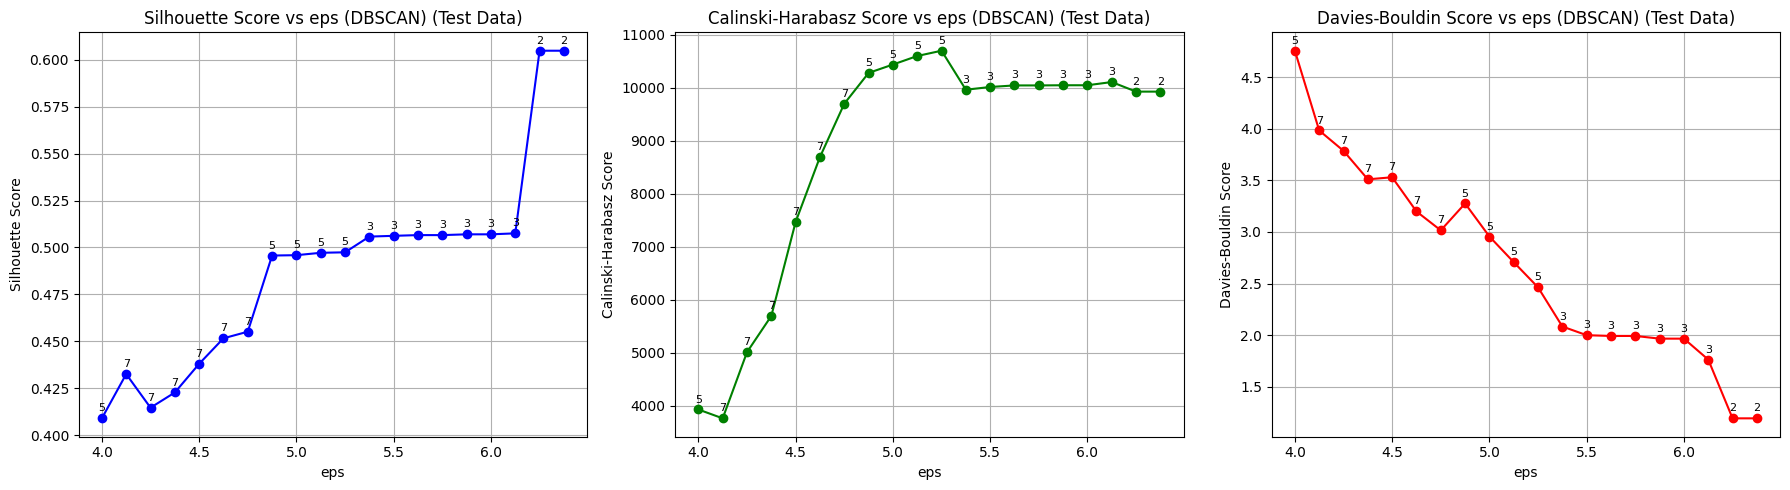

In [94]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(eps_values, silhouette_scores, marker='o', color='blue')
for i, txt in enumerate(n_clusters_list):
    plt.annotate(txt, (eps_values[i], silhouette_scores[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.title('Silhouette Score vs eps (DBSCAN) (Test Data)')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(eps_values, calinski_scores, marker='o', color='green')
for i, txt in enumerate(n_clusters_list):
    plt.annotate(txt, (eps_values[i], calinski_scores[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.title('Calinski-Harabasz Score vs eps (DBSCAN) (Test Data)')
plt.xlabel('eps')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(eps_values, davies_scores, marker='o', color='red')
for i, txt in enumerate(n_clusters_list):
    if not np.isnan(davies_scores[i]):
        plt.annotate(txt, (eps_values[i], davies_scores[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.title('Davies-Bouldin Score vs eps (DBSCAN) (Test Data)')
plt.xlabel('eps')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)

plt.tight_layout()
plt.show()


#### Wybór

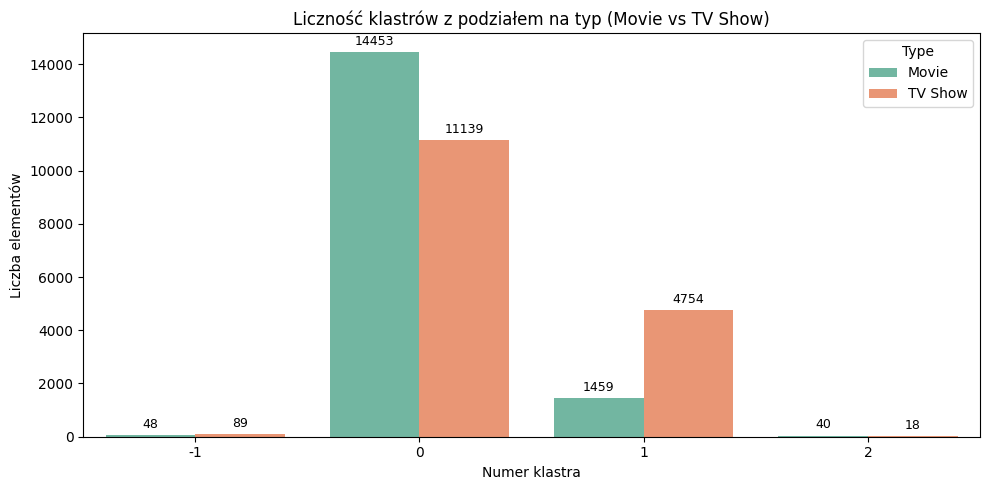

In [95]:
db = DBSCAN(eps=4.75, min_samples=40)
db.fit(X_train)
df_klastry['dbscan_cluster_number'] = db.fit_predict(X)

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_klastry, x='dbscan_cluster_number', hue='type', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

plt.title('Liczność klastrów z podziałem na typ (Movie vs TV Show)')
plt.xlabel('Numer klastra')
plt.ylabel('Liczba elementów')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-06-06 11:10:22.296] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


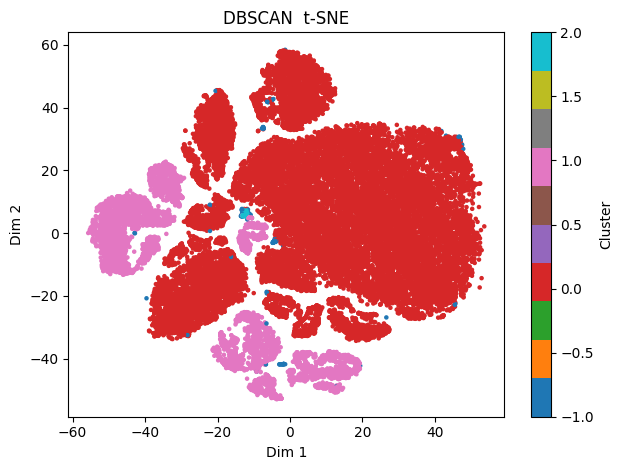

In [96]:
X_gpu = cp.asarray(X)

tsne = TSNE(n_components=2, perplexity=30,n_neighbors=90, n_iter=500, random_state=42)
X_tsne_gpu = tsne.fit_transform(X_gpu)

X_tsne = cp.asnumpy(X_tsne_gpu)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_klastry['dbscan_cluster_number'], cmap='tab10', s=5)
plt.title("DBSCAN  t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


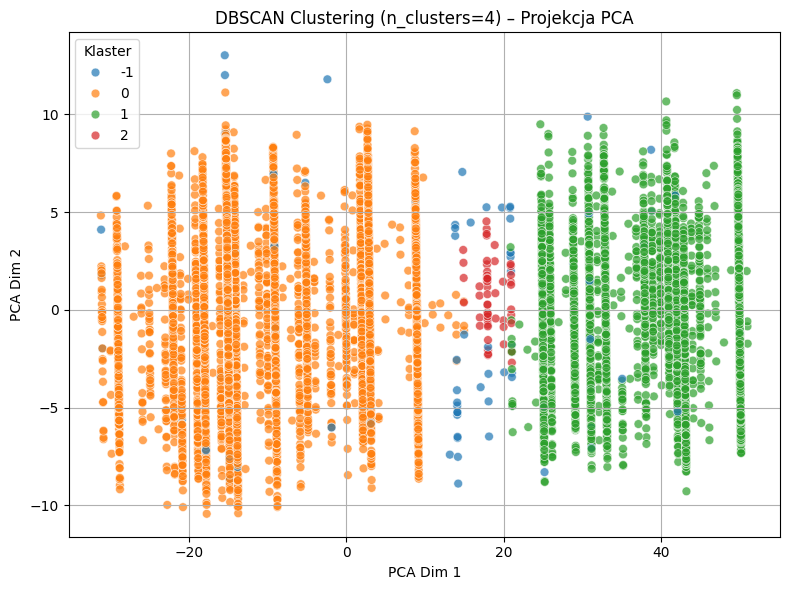

In [97]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_klastry['dbscan_cluster_number'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title(f"DBSCAN Clustering (n_clusters={len(set(df_klastry['dbscan_cluster_number']))}) – Projekcja PCA")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

NIE NADAJE SIĘ skrajnie

### Model BIRCH

Bardzo szybko działający model, buduje hierarchiczną strukturę drzewiastą, która kompresuje dane. Model sam szuka odpowiedniej liczby klastrów, natomiast musimy znaleźć mu odpowiedni parametr 'threshold', czyli maksymalny promień (odległość) klastra w CF-tree (Condensed Feature Tree).

#### Szacowania

In [37]:
threshold_values = np.arange(6.05, 6.7, 0.06)
silhouette_scores = []
calinski_scores = []
davies_scores = []
n_clusters_list = []

for t in threshold_values:
    print(f"Threshold: {t}")
    birch_model = Birch(threshold=t, branching_factor=50, n_clusters=None)
    birch_model.fit(X_train)
    labels_test = birch_model.predict(X_test)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_clusters_list.append(n_clusters)

    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(X_test, labels_test))
        calinski_scores.append(calinski_harabasz_score(X_test, labels_test))
        davies_scores.append(davies_bouldin_score(X_test, labels_test))
    else:
        silhouette_scores.append(-1)
        calinski_scores.append(-1)
        davies_scores.append(np.nan)


Threshold: 6.05
Threshold: 6.109999999999999
Threshold: 6.169999999999999
Threshold: 6.229999999999999
Threshold: 6.289999999999998
Threshold: 6.349999999999998
Threshold: 6.4099999999999975
Threshold: 6.469999999999997
Threshold: 6.529999999999997
Threshold: 6.589999999999996
Threshold: 6.649999999999996


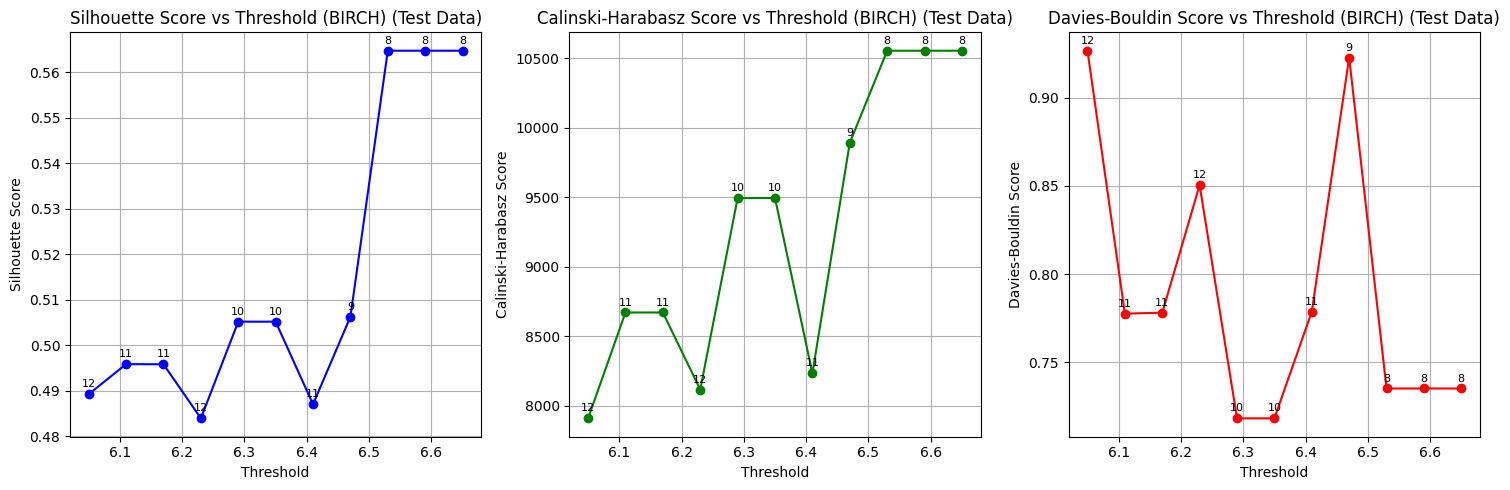

In [38]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(threshold_values, silhouette_scores, marker='o', color='blue')
for i, txt in enumerate(n_clusters_list):
    plt.annotate(txt, (threshold_values[i], silhouette_scores[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.title('Silhouette Score vs Threshold (BIRCH) (Test Data)')
plt.xlabel('Threshold')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(threshold_values, calinski_scores, marker='o', color='green')
for i, txt in enumerate(n_clusters_list):
    plt.annotate(txt, (threshold_values[i], calinski_scores[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.title('Calinski-Harabasz Score vs Threshold (BIRCH) (Test Data)')
plt.xlabel('Threshold')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(threshold_values, davies_scores, marker='o', color='red')
for i, txt in enumerate(n_clusters_list):
    if not np.isnan(davies_scores[i]):
        plt.annotate(txt, (threshold_values[i], davies_scores[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.title('Davies-Bouldin Score vs Threshold (BIRCH) (Test Data)')
plt.xlabel('Threshold')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Wybór

Liczba klastrów: 8


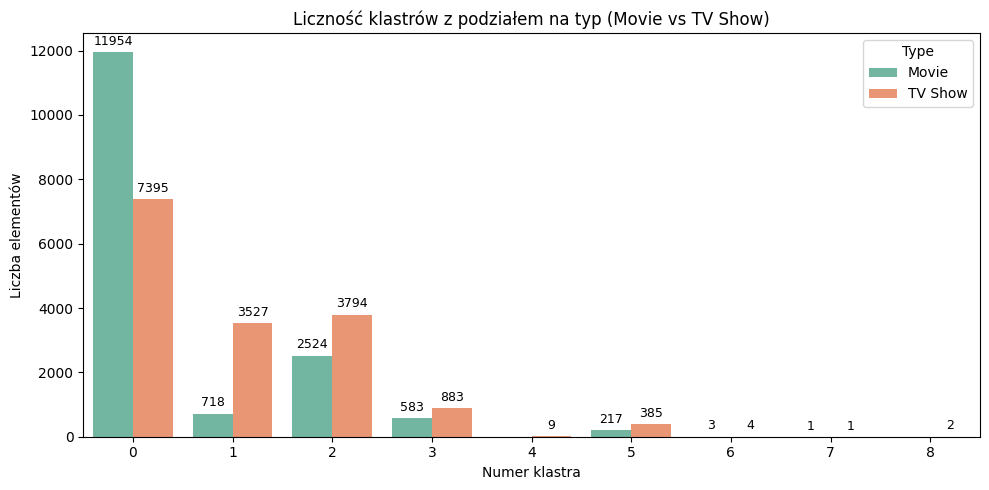

In [58]:
birch_model = Birch(threshold=6.53, branching_factor=50, n_clusters=None)
birch_model.fit(X_train)
df_klastry['birch_cluster_number'] = birch_model.predict(X)
labels = birch_model.predict(X_test)
print("Liczba klastrów:", len(set(labels)))

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_klastry, x='birch_cluster_number', hue='type', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

plt.title('Liczność klastrów z podziałem na typ (Movie vs TV Show)')
plt.xlabel('Numer klastra')
plt.ylabel('Liczba elementów')
plt.legend(title='Type')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-06-06 10:40:35.839] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


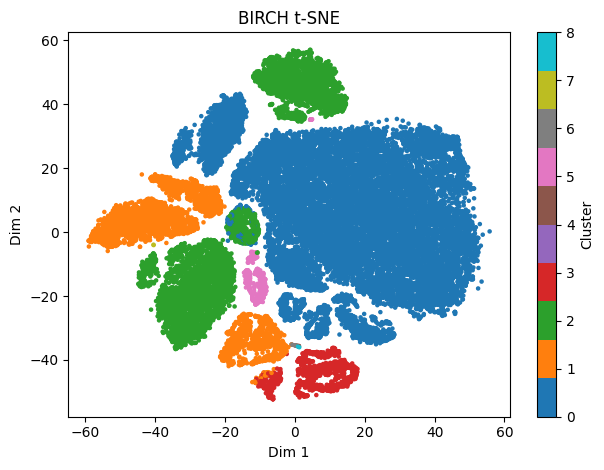

In [59]:
X_gpu = cp.asarray(X)

tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
X_tsne_gpu = tsne.fit_transform(X_gpu)

X_tsne = cp.asnumpy(X_tsne_gpu)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_klastry['birch_cluster_number'], cmap='tab10', s=5)
plt.title("BIRCH t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


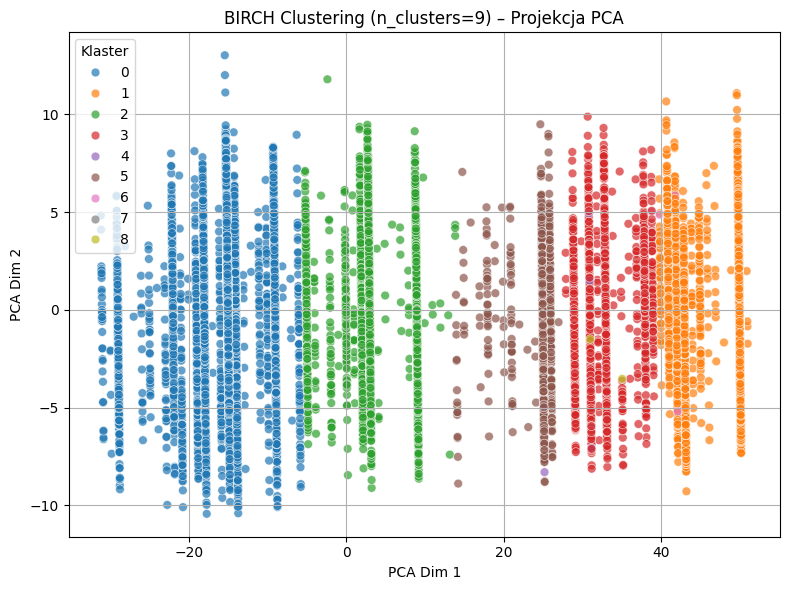

In [60]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_klastry['birch_cluster_number'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title(f"BIRCH Clustering (n_clusters={len(set(df_klastry['birch_cluster_number']))}) – Projekcja PCA")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### Gausian Mixture

#### Szacowania

In [42]:
cluster_range = range(4, 8)
gmm_models = {}
gmm_silhouette = {}
gmm_calinski = {}
gmm_davies = {}

for k in cluster_range:
    print(f"Liczba klastrów: {k}")
    gmm = GaussianMixture(n_components=k, covariance_type='full',max_iter=50, tol= 0.0005, n_init=3, random_state=42)
    gmm.fit(X_train)
    labels_test = gmm.predict(X_test)

    gmm_models[k] = gmm
    gmm_silhouette[k] = silhouette_score(X_test, labels_test)
    gmm_calinski[k] = calinski_harabasz_score(X_test, labels_test)
    gmm_davies[k] = davies_bouldin_score(X_test, labels_test)


Liczba klastrów: 4
Liczba klastrów: 5
Liczba klastrów: 6
Liczba klastrów: 7


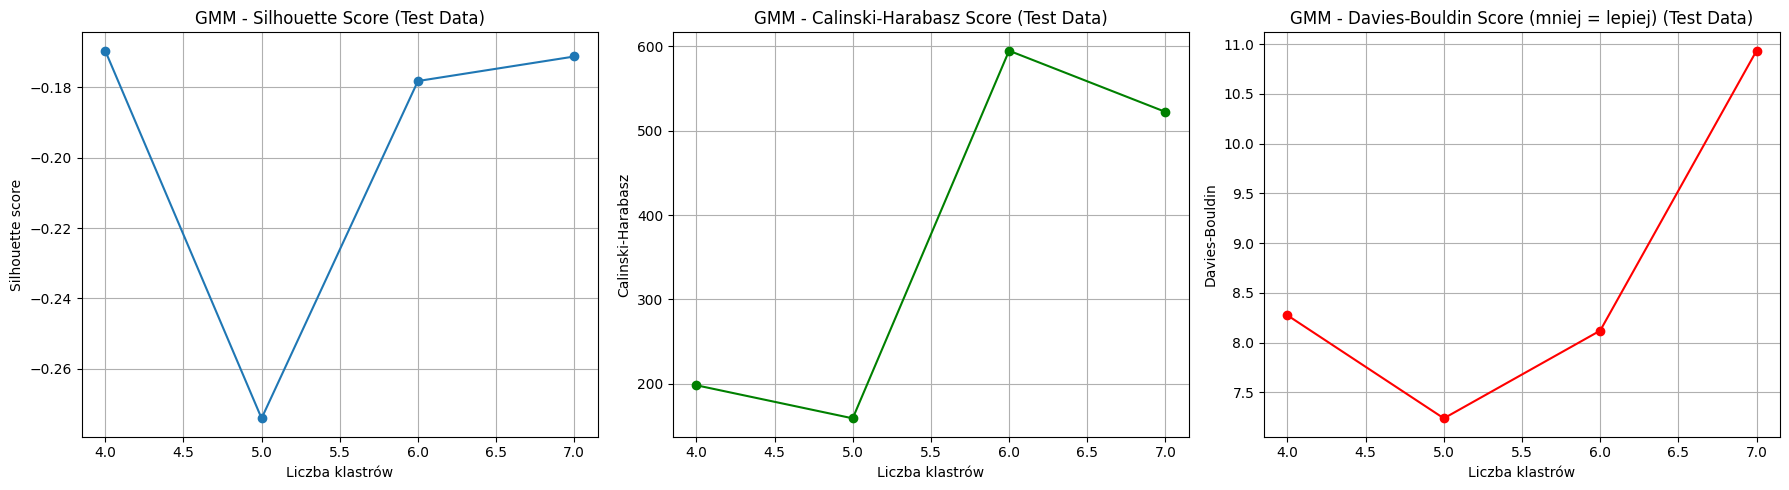

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(list(gmm_silhouette.keys()), list(gmm_silhouette.values()), marker='o')
axes[0].set_title("GMM - Silhouette Score (Test Data)")
axes[0].set_xlabel("Liczba klastrów")
axes[0].set_ylabel("Silhouette score")
axes[0].grid(True)

axes[1].plot(list(gmm_calinski.keys()), list(gmm_calinski.values()), marker='o', color='green')
axes[1].set_title("GMM - Calinski-Harabasz Score (Test Data)")
axes[1].set_xlabel("Liczba klastrów")
axes[1].set_ylabel("Calinski-Harabasz")
axes[1].grid(True)

axes[2].plot(list(gmm_davies.keys()), list(gmm_davies.values()), marker='o', color='red')
axes[2].set_title("GMM - Davies-Bouldin Score (mniej = lepiej) (Test Data)")
axes[2].set_xlabel("Liczba klastrów")
axes[2].set_ylabel("Davies-Bouldin")
axes[2].grid(True)

plt.tight_layout()
plt.show()

#### Wybory

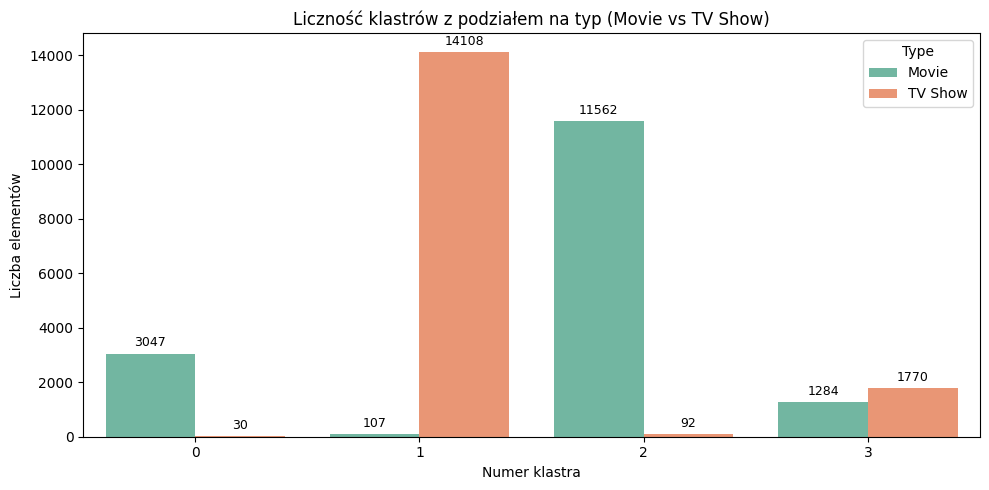

In [44]:
gmm = GaussianMixture(n_components=4, covariance_type='full',max_iter=100, tol= 0.0005, n_init=5, random_state=42)
gmm.fit(X_train)
df_klastry['gmm_clusters'] = gmm.predict(X)

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_klastry, x='gmm_clusters', hue='type', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

plt.title('Liczność klastrów z podziałem na typ (Movie vs TV Show)')
plt.xlabel('Numer klastra')
plt.ylabel('Liczba elementów')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-06-06 10:34:50.504] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


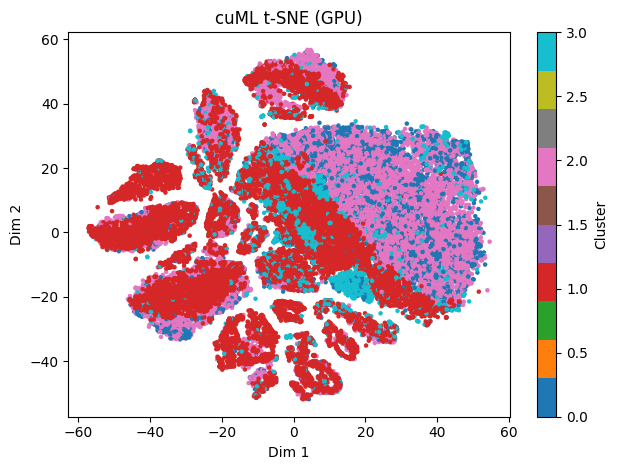

In [45]:
X_gpu = cp.asarray(X)

tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
X_tsne_gpu = tsne.fit_transform(X_gpu)

X_tsne = cp.asnumpy(X_tsne_gpu)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_klastry['gmm_clusters'], cmap='tab10', s=5)
plt.title("Gaussian Mixture Clustering t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

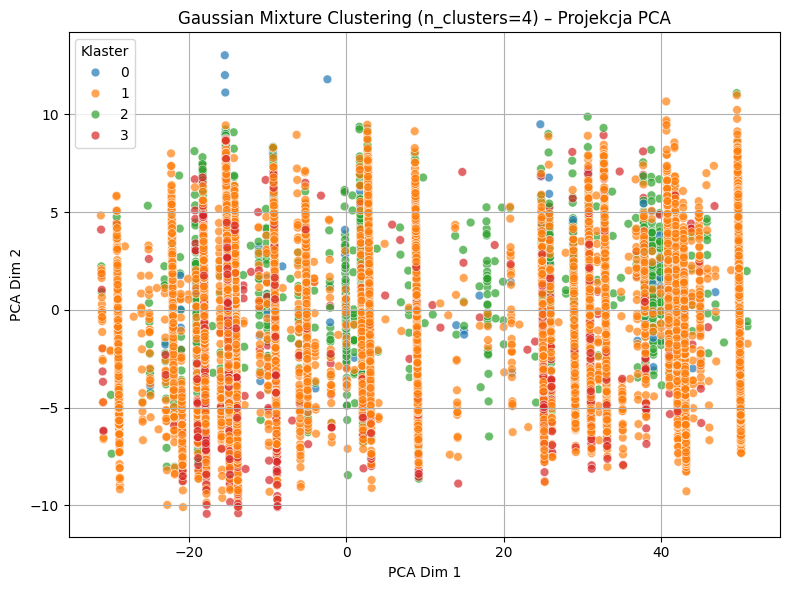

In [46]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_klastry['gmm_clusters'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title(f"Gaussian Mixture Clustering (n_clusters={len(set(df_klastry['gmm_clusters']))}) – Projekcja PCA")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### Wnioski
Metryki nie są absolutne, bliżej im do sugestii. t-SNE pokazuje że ilość klastrów jest większa niż 4. BIRCH pozornie ma lepsze wyniki niż inne modele, jednak liczność w pojedyńczych klastrach jest niska. Możemy też zobaczyć Gausian mixture - wszystkie metryki są bardzo negatywne w porównaniu do innych modeli. Może to oznaczać "nieeliptyczność" klastrów, są one silnie skorelowane, przez co model nie daje optymalnych rezultatów, dodatkowo jest wymagający obliczeniowo. \\
#### Jaki ostatecznie model wybieramy?
Najlepiej będzie się sprawdzał model Mini Batches K-średnich. Praktycznie wszystkie metryki są lepsze. Mini batches lepiej radzi sobie z szumem niż K-średnich co może być przyczyną lepszych wyników.

# Hiperparametryzacja
Używamy do optymalizacji metrykę Silhouette - najbardziej nadaje się do optymalizacji pod względem "jakości" klastrów.

## Szukanie dla różnych klastrów

In [99]:
def parametry(trial):
    n_clusters = trial.suggest_int("n_clusters", 14, 14)
    init = trial.suggest_categorical("init", ["k-means++", "random"])
    max_iter = trial.suggest_int("max_iter", 100, 500)
    batch_size = trial.suggest_int("batch_size", 50, 1024)

    mbkmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        init=init,
        max_iter=max_iter,
        batch_size=batch_size,
        random_state=1
    )

    mbkmeans.fit(X_train)
    score = silhouette_score(X_train, mbkmeans.labels_)
    return score


In [100]:
study = optuna.create_study(direction="maximize")
study.optimize(parametry, n_trials=50)

[I 2025-06-06 13:10:53,628] A new study created in memory with name: no-name-99f8763b-1970-4b04-a602-77891c6f8698
[I 2025-06-06 13:11:02,467] Trial 0 finished with value: 0.24515939079060745 and parameters: {'n_clusters': 14, 'init': 'k-means++', 'max_iter': 148, 'batch_size': 814}. Best is trial 0 with value: 0.24515939079060745.
[I 2025-06-06 13:11:09,992] Trial 1 finished with value: 0.20641603788981322 and parameters: {'n_clusters': 14, 'init': 'random', 'max_iter': 205, 'batch_size': 681}. Best is trial 0 with value: 0.24515939079060745.
[I 2025-06-06 13:11:18,145] Trial 2 finished with value: 0.23110380715766204 and parameters: {'n_clusters': 14, 'init': 'random', 'max_iter': 130, 'batch_size': 178}. Best is trial 0 with value: 0.24515939079060745.
[I 2025-06-06 13:11:26,696] Trial 3 finished with value: 0.23006098169510497 and parameters: {'n_clusters': 14, 'init': 'random', 'max_iter': 414, 'batch_size': 541}. Best is trial 0 with value: 0.24515939079060745.
[I 2025-06-06 13:11

In [101]:
print(study.best_params)
print(study.best_value)

{'n_clusters': 14, 'init': 'random', 'max_iter': 298, 'batch_size': 952}
0.258826996120842


In [102]:
with open("optuna_silhouette.txt", "a") as f:
    f.write("Najlepsze parametry:\n")
    for key, value in study.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nNajlepszy wynik (silhouette score): {study.best_value:.4f}\n")


In [81]:
def parametrych(trial):
    n_clusters = trial.suggest_int("n_clusters", 8, 17)
    init = trial.suggest_categorical("init", ["k-means++", "random"])
    max_iter = trial.suggest_int("max_iter", 100, 500)
    batch_size = trial.suggest_int("batch_size", 50, 1024)

    mbkmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        init=init,
        max_iter=max_iter,
        batch_size=batch_size,
        random_state=1
    )

    mbkmeans.fit(X_train)
    score = calinski_harabasz_score(X_train, mbkmeans.labels_)
    return score
studych = optuna.create_study(direction="maximize")
studych.optimize(parametrych, n_trials=100)
print(studych.best_params)
print(studych.best_value)

[I 2025-06-06 12:32:46,701] A new study created in memory with name: no-name-da33df5c-99ce-4a7b-ad06-4eb1082dc1f2
[I 2025-06-06 12:32:46,911] Trial 0 finished with value: 60648.47813298959 and parameters: {'n_clusters': 11, 'init': 'random', 'max_iter': 315, 'batch_size': 764}. Best is trial 0 with value: 60648.47813298959.
[I 2025-06-06 12:32:47,036] Trial 1 finished with value: 52501.97711710455 and parameters: {'n_clusters': 13, 'init': 'random', 'max_iter': 314, 'batch_size': 323}. Best is trial 0 with value: 60648.47813298959.
[I 2025-06-06 12:32:47,138] Trial 2 finished with value: 53563.69963581827 and parameters: {'n_clusters': 15, 'init': 'random', 'max_iter': 127, 'batch_size': 394}. Best is trial 0 with value: 60648.47813298959.
[I 2025-06-06 12:32:47,260] Trial 3 finished with value: 49817.789446922936 and parameters: {'n_clusters': 8, 'init': 'random', 'max_iter': 449, 'batch_size': 499}. Best is trial 0 with value: 60648.47813298959.
[I 2025-06-06 12:32:47,451] Trial 4 fi

{'n_clusters': 8, 'init': 'k-means++', 'max_iter': 324, 'batch_size': 701}
79121.15164405656


In [82]:
with open("optuna_calinski_harabasz.txt", "a") as f:
    for key, value in studych.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nNajlepszy wynik: {studych.best_value:.4f}\n")


In [83]:
def parametrydb(trial):
    n_clusters = trial.suggest_int("n_clusters", 8, 17)
    init = trial.suggest_categorical("init", ["k-means++", "random"])
    max_iter = trial.suggest_int("max_iter", 100, 500)
    batch_size = trial.suggest_int("batch_size", 50, 1024)

    mbkmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        init=init,
        max_iter=max_iter,
        batch_size=batch_size,
        random_state=1
    )

    mbkmeans.fit(X_train)
    score = -davies_bouldin_score(X_train, mbkmeans.labels_)
    return score
studydb = optuna.create_study(direction="maximize")
studydb.optimize(parametrydb, n_trials=100)
print(studydb.best_params)
print(studydb.best_value)

[I 2025-06-06 12:33:01,239] A new study created in memory with name: no-name-aadb2c24-de37-43ab-8e8d-15b155153c4a
[I 2025-06-06 12:33:01,315] Trial 0 finished with value: -1.274816297024561 and parameters: {'n_clusters': 8, 'init': 'random', 'max_iter': 217, 'batch_size': 78}. Best is trial 0 with value: -1.274816297024561.
[I 2025-06-06 12:33:01,401] Trial 1 finished with value: -1.305399762834846 and parameters: {'n_clusters': 10, 'init': 'k-means++', 'max_iter': 429, 'batch_size': 969}. Best is trial 0 with value: -1.274816297024561.
[I 2025-06-06 12:33:01,478] Trial 2 finished with value: -1.603760244016486 and parameters: {'n_clusters': 16, 'init': 'k-means++', 'max_iter': 422, 'batch_size': 155}. Best is trial 0 with value: -1.274816297024561.
[I 2025-06-06 12:33:01,531] Trial 3 finished with value: -1.3184312936545919 and parameters: {'n_clusters': 13, 'init': 'random', 'max_iter': 410, 'batch_size': 217}. Best is trial 0 with value: -1.274816297024561.
[I 2025-06-06 12:33:01,59

{'n_clusters': 9, 'init': 'random', 'max_iter': 271, 'batch_size': 662}
-1.0843373332162116


In [84]:
with open("optuna_davies_bouldin.txt", "a") as f:
    for key, value in studydb.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nNajlepszy wynik: {studydb.best_value:.4f}\n")

## Przedstawienie wyników

| Metryka           | n_clusters | init       | max_iter | batch_size | Najlepszy wynik       |
|-------------------|------------|------------|----------|------------|-----------------------|
| Silhouette score  | 5          | k-means++  | 151      | 489        | 0.58                  |
| Silhouette score  | 7          | k-means++  | 275      | 550        | 0.4754                |
| Silhouette score  | 8          | k-means++  | 337      | 728        | 0.4161                |
| Calinski-Harabasz | 5          | k-means++  | 203      | 253        | 96411.7299            |
| Calinski-Harabasz | 6          | k-means++  | 270      | 697        | 88720.1089            |
| Calinski-Harabasz | 7          | k-means++  | 460      | 609        | 82621.5523            |
| Calinski-Harabasz | 8          | k-means++  | 324      | 701        | 79121.1516            |
| Davies-Bouldin    | 5          | random     | 263      | 247        | -0.7643               |
| Davies-Bouldin    | 6          | k-means++  | 104      | 271        | -0.8881               |
| Davies-Bouldin    | 7          | k-means++  | 322      | 576        | -0.9840               |
| Davies-Bouldin    | 9          | random     | 271      | 662        | -1.0843               |

Możemy zauważyć że dla zawsze im mniej klastrów tm lepiej z wyjątkiem silhuette dla 6-17 klastrów, gdzie zoptymalizowano do 7 oraz Davies-Bouldin gdzie dla zakresu od 8-17 wybrano 9 klastrów.
W związku z tym, że generalnie dla 7 klastrów wyniki są w dużej mierze jak na wartość klastrów większą niż 5, użyjemy jej oraz porównamy jak się zmienia w zależności od optymalizowanej metryki

In [90]:
minikmeans_silhouette = MiniBatchKMeans(
    n_clusters=7,
    init='k-means++',
    max_iter=275,
    batch_size=550,
    random_state=1
)

minikmeans_calinski = MiniBatchKMeans(
    n_clusters=7,
    init='k-means++',
    max_iter=460,
    batch_size=609,
    random_state=1
)

minikmeans_davies = MiniBatchKMeans(
    n_clusters=7,
    init='k-means++',
    max_iter=322,
    batch_size=576,
    random_state=1
)

minikmeans_default = MiniBatchKMeans(
    n_clusters=7,
    init='k-means++',
    random_state=1
)

minikmeans_silhouette.fit(X_train)
minikmeans_calinski.fit(X_train)
minikmeans_davies.fit(X_train)
minikmeans_default.fit(X_train)

df_optymalizacja['minikmeans_silhouette'] = minikmeans_silhouette.predict(X)
df_optymalizacja['minikmeans_calinski'] = minikmeans_calinski.predict(X)
df_optymalizacja['minikmeans_davies'] = minikmeans_davies.predict(X)
df_optymalizacja['minikmeans_default'] = minikmeans_default.predict(X)


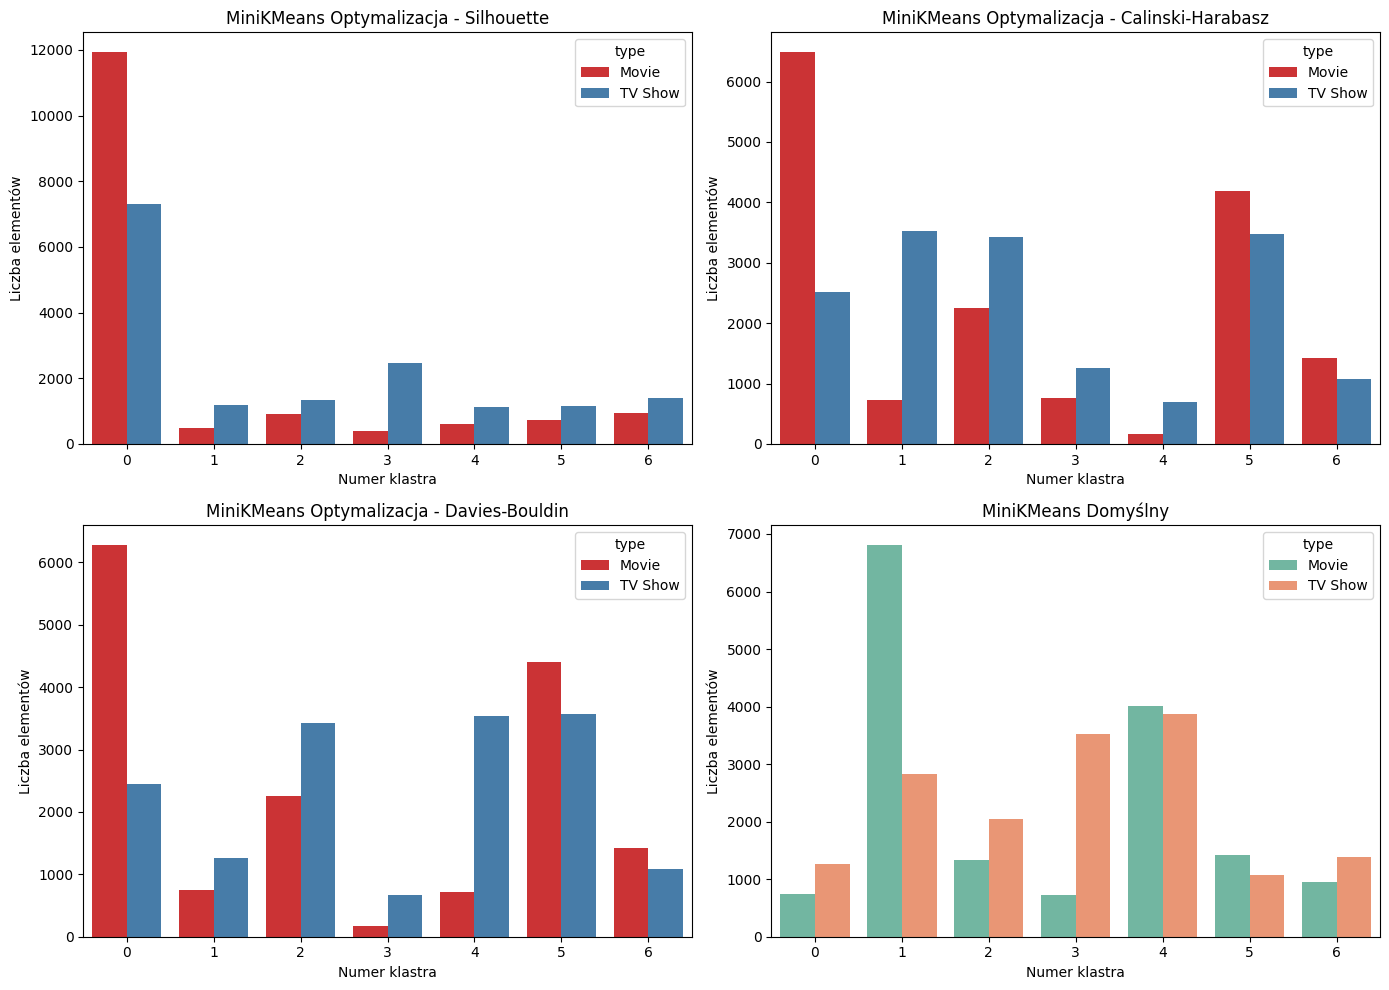

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.countplot(data=df_optymalizacja, x='minikmeans_silhouette', hue='type', palette='Set1')
plt.title("MiniKMeans Optymalizacja - Silhouette")
plt.xlabel("Numer klastra")
plt.ylabel("Liczba elementów")

plt.subplot(2, 2, 2)
sns.countplot(data=df_optymalizacja, x='minikmeans_calinski', hue='type', palette='Set1')
plt.title("MiniKMeans Optymalizacja - Calinski-Harabasz")
plt.xlabel("Numer klastra")
plt.ylabel("Liczba elementów")

plt.subplot(2, 2, 3)
sns.countplot(data=df_optymalizacja, x='minikmeans_davies', hue='type', palette='Set1')
plt.title("MiniKMeans Optymalizacja - Davies-Bouldin")
plt.xlabel("Numer klastra")
plt.ylabel("Liczba elementów")

plt.subplot(2, 2, 4)
sns.countplot(data=df_optymalizacja, x='minikmeans_default', hue='type', palette='Set2')
plt.title("MiniKMeans Domyślny")
plt.xlabel("Numer klastra")
plt.ylabel("Liczba elementów")

plt.tight_layout()
plt.show()


Używamy UMAP

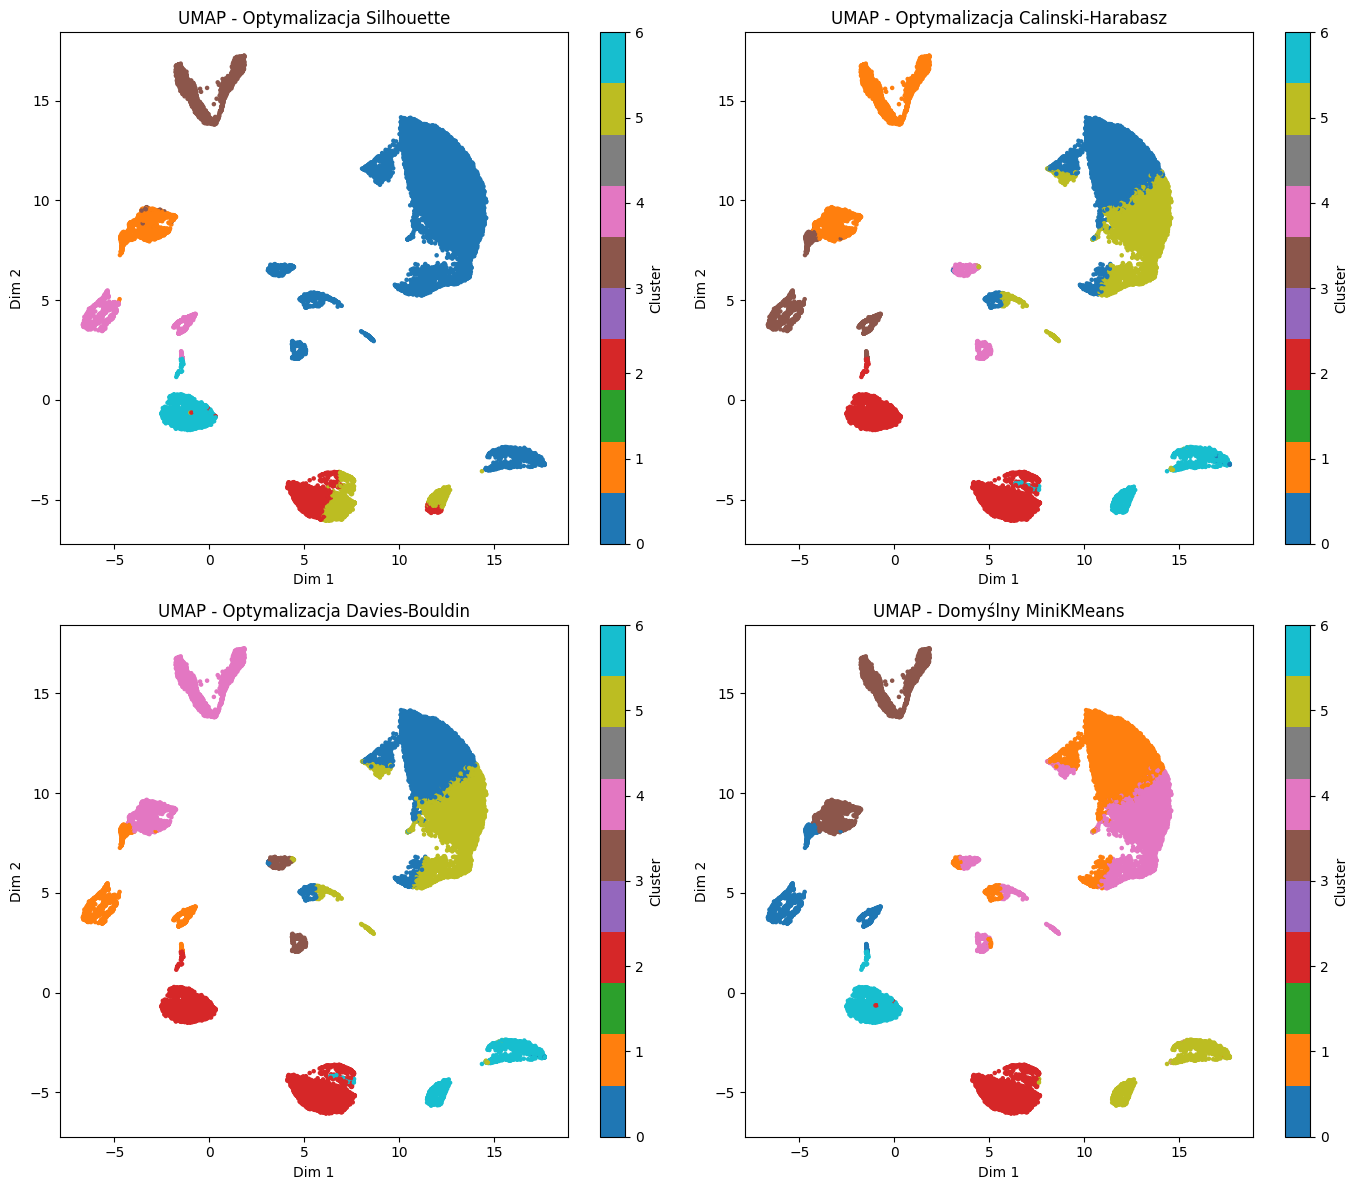

In [97]:
reducer = umap.UMAP(n_components=2, n_neighbors=30, random_state=42)
X_umap = reducer.fit_transform(X)

import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_components=2, n_neighbors=30, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_optymalizacja['minikmeans_silhouette'], cmap='tab10', s=5)
plt.title("UMAP - Optymalizacja Silhouette")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')

plt.subplot(2, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_optymalizacja['minikmeans_calinski'], cmap='tab10', s=5)
plt.title("UMAP - Optymalizacja Calinski-Harabasz")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')

plt.subplot(2, 2, 3)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_optymalizacja['minikmeans_davies'], cmap='tab10', s=5)
plt.title("UMAP - Optymalizacja Davies-Bouldin")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')

plt.subplot(2, 2, 4)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_optymalizacja['minikmeans_default'], cmap='tab10', s=5)
plt.title("UMAP - Domyślny MiniKMeans")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()



**Widzimy że jest wyróżnionych 14 klastrów, wiec zobaczymy za chwilę jeszcze jak by wyglądały wszystkie wykresy również dla zoptymalizowanego pod tym kątem modelu**

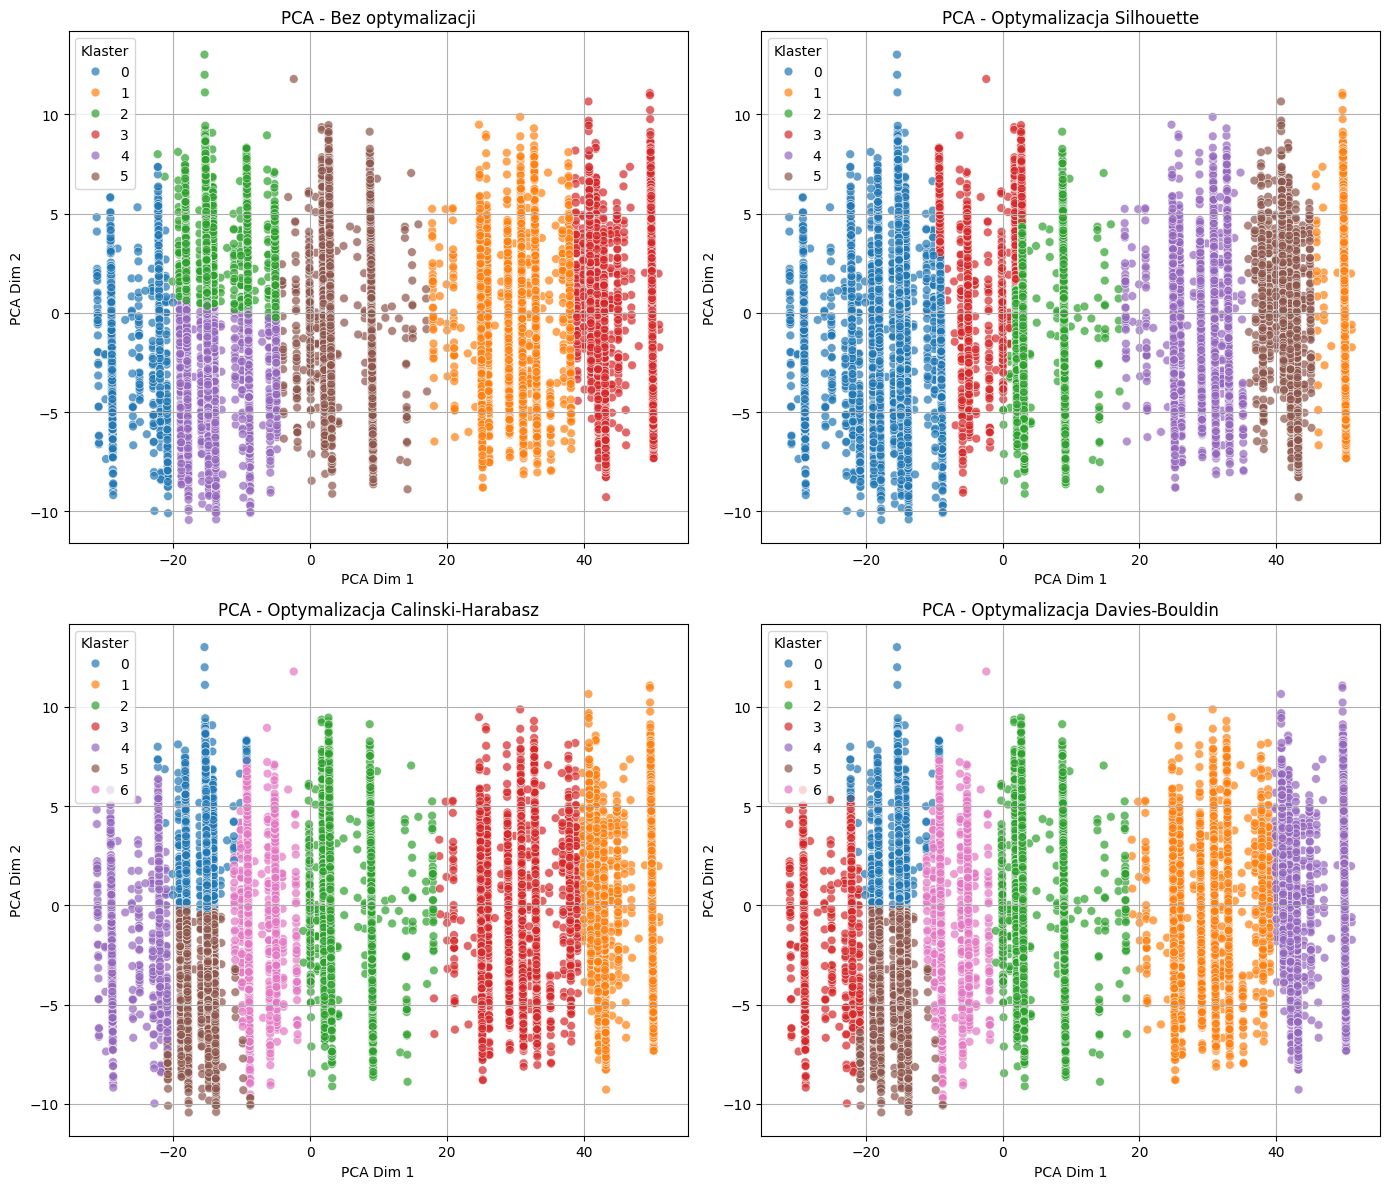

In [98]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_optymalizacja['minikmeans_nieoptymalizacja'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title("PCA - Bez optymalizacji")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)

plt.subplot(2, 2, 2)
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_optymalizacja['minikmeans_optymalizacja'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title("PCA - Optymalizacja Silhouette")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)

plt.subplot(2, 2, 3)
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_optymalizacja['minikmeans_calinski'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title("PCA - Optymalizacja Calinski-Harabasz")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)

plt.subplot(2, 2, 4)
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_optymalizacja['minikmeans_davies'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title("PCA - Optymalizacja Davies-Bouldin")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)

plt.tight_layout()
plt.show()


### Wyniki Dla 14 klastrów

In [112]:
minikmeans_custom = MiniBatchKMeans(
    n_clusters=14,
    init='random',
    max_iter=298,
    batch_size=952,
    random_state=42
)

minikmeans_default14 = MiniBatchKMeans(
    n_clusters=14,
    init='k-means++',
    random_state=42
)

minikmeans_custom.fit(X)
minikmeans_default14.fit(X)

df_optymalizacja['minikmeans_custom'] = minikmeans_custom.predict(X)
df_optymalizacja['minikmeans_default14'] = minikmeans_default14.predict(X)


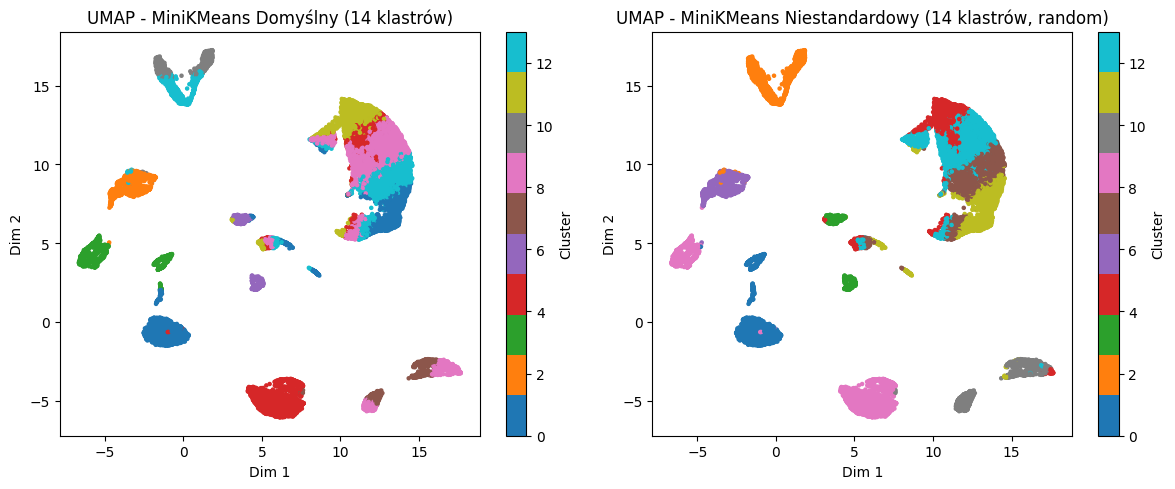

In [113]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_optymalizacja['minikmeans_default14'], cmap='tab10', s=5)
plt.title("UMAP - MiniKMeans Domyślny (14 klastrów)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')

plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_optymalizacja['minikmeans_custom'], cmap='tab10', s=5)
plt.title("UMAP - MiniKMeans Niestandardowy (14 klastrów, random)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()


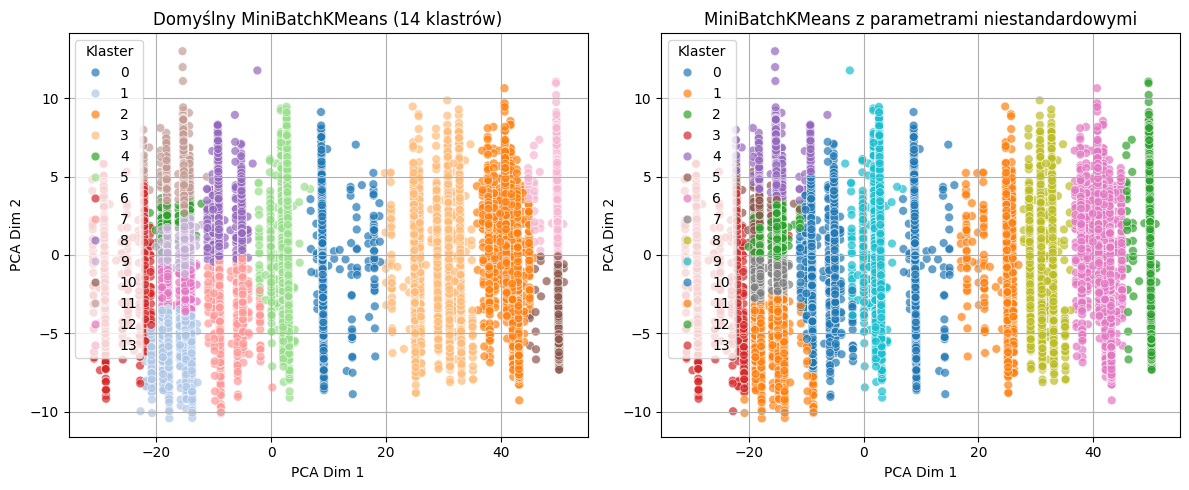

In [109]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_optymalizacja['minikmeans_default14'],
    palette="tab20",
    alpha=0.7,
    s=40
)
plt.title("Domyślny MiniBatchKMeans (14 klastrów)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)

plt.subplot(1, 2, 2)

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_optymalizacja['minikmeans_custom'],
    palette="tab10",
    alpha=0.7,
    s=40
)
plt.title("MiniBatchKMeans z parametrami niestandardowymi")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Klaster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


## Wnioski
Dla 14 klastrów, grupy nie są optymalne, najlepsze wyniki są dla 7 klastrów optymalizowanych po metryce Silhuette, gdzie większość klastrów jest widocznie wyodrębniona.

In [114]:
df_optymalizacja.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32000 entries, 0 to 15999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   type                         32000 non-null  object 
 1   title                        32000 non-null  object 
 2   director                     32000 non-null  object 
 3   cast                         32000 non-null  object 
 4   release_year                 32000 non-null  int64  
 5   rating                       32000 non-null  float64
 6   genres                       32000 non-null  object 
 7   language                     32000 non-null  object 
 8   description                  32000 non-null  object 
 9   popularity                   32000 non-null  float64
 10  vote_count                   32000 non-null  int64  
 11  text                         32000 non-null  object 
 12  minikmeans_optymalizacja     32000 non-null  int32  
 13  minikmeans_nieoptymal

## Jakie opisy są w centrach klastrów



In [121]:
import pandas as pd
import textwrap

pd.set_option('display.max_colwidth', None)

def wrap_text_by_words(text, words_per_line=20):
    words = text.split()
    wrapped_lines = [' '.join(words[i:i + words_per_line]) for i in range(0, len(words), words_per_line)]
    return '\n'.join(wrapped_lines)

print("📄 Opisy najbliższe centroidom klastrów (Silhouette):")
for cluster_label, doc_index in closest_docs_indices.items():
    full_description = df_optymalizacja.loc[doc_index, 'description']
    if isinstance(full_description, pd.Series):
        full_description = full_description.iloc[0]

    wrapped_description = wrap_text_by_words(full_description, words_per_line=20)

    print(f"\n🔹 Klaster {cluster_label}:\n")
    print(wrapped_description)
    print("-" * 100)

📄 Opisy najbliższe centroidom klastrów (Silhouette):

🔹 Klaster 0:

Miguel, a heroic Spanish doctor, puts himself in harm's way to deliver medical treatment to the victims of military uprisings
in Africa.
----------------------------------------------------------------------------------------------------

🔹 Klaster 1:

With their teen hormones raging, three high school boys help one another explore their curiosity about the opposite sex and
love in this raunchy comedy.
----------------------------------------------------------------------------------------------------

🔹 Klaster 2:

"Loro", in two parts, is a period movie that chronicles, as a fiction story, events likely happened in Italy (or
even made up) between 2006 and 2010. "Loro" wants to suggest in portraits and glimps, through a composite constellation of
characters, a moment in history, now definitively ended, which can be described in a very summary picture of the events
as amoral, decadent but extraordinarily alive. Additio